Luca Dal Zotto
1236343

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import time
import itertools

from sklearn import preprocessing
from sklearn.model_selection import KFold, ParameterGrid

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

# Dataset

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [3]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-02-13 08:55:49--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-02-13 08:55:50 (61.3 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-02-13 08:55:50--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

How to load the data:

In [4]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [5]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


### Data exploration

Compute the shape of the datasets

In [6]:
print("train_df shape: " + str(train_df.shape))
print("test_df shape: " + str(test_df.shape))

train_df shape: (100, 2)
test_df shape: (100, 2)


Check if there are missing values

In [7]:
print('Is there any missing value in the training set?')
print(train_df.isnull().any(),'\n')
print('Is there any missing value in the test set?')
print(test_df.isnull().any())

Is there any missing value in the training set?
input    False
label    False
dtype: bool 

Is there any missing value in the test set?
input    False
label    False
dtype: bool


Visualize the first 5 rows of the training set

In [8]:
train_df.head()

input     label
0 -4.787870 -1.216804
1 -3.509057  3.277581
2 -3.855373  2.621375
3 -4.083518  1.046088
4 -4.230588  1.228874

To have a better idea, visualize the first and last 10 rows of the training set

In [9]:
first_and_lasts = list(range(0,10)) + list(range(-10, 0))
train_df.iloc[first_and_lasts]

input     label
0  -4.787870 -1.216804
1  -3.509057  3.277581
2  -3.855373  2.621375
3  -4.083518  1.046088
4  -4.230588  1.228874
5  -4.452021 -0.115171
6  -3.664075  3.534664
7  -4.209050  1.979337
8  -4.436854  0.627938
9  -3.440161  2.865783
90  4.143876  3.357217
91  4.638587  5.068925
92  4.100037  3.024834
93  4.890663  6.435849
94  4.066811  1.890611
95  4.745864  5.839698
96  4.454523  3.584919
97  4.547246  4.586484
98  4.649648  5.185536
99  4.781836  6.616912

Plot all training points:

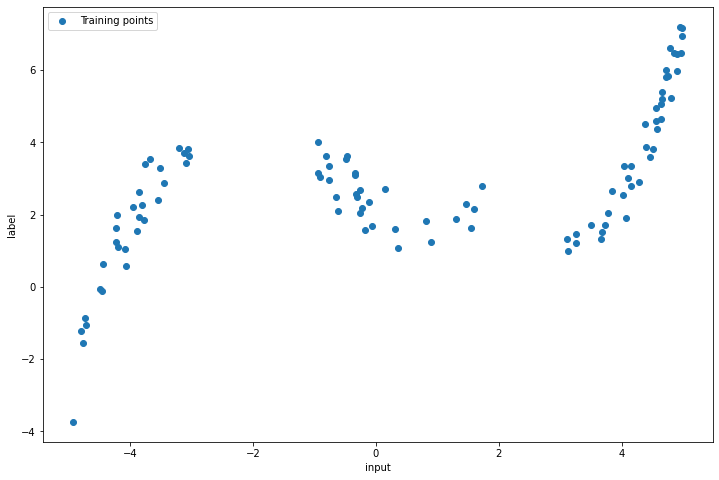

In [10]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

**Comment #1:** it seems that the first rows correspond to the points on the left-hand side of the plot, while the last ones correspond to the right-hand side. This observation is of crucial importance if we decide to divide the training set into training and validation set: in that case, we need to shuffle the points, otherwise we may have a training set with points on the left, and a validation set with points on the right.

**Comment #2:** from this graphical representation, we notice that certain input ranges are not present in the training set: indeed we have no sample with input between (approx.) -3 and -1 and between 2 and 3. Moreover, there is only one sample with a label value smaller than -2. If the test set includes points in these regions, probably the network will not be very accurate, since those samples will be different from what it has seen during training. 

In [11]:
train_df = train_df.sample(frac=1, random_state=0)

In [12]:
train_df

input     label
26 -3.946958  2.201153
86  4.960311  6.460902
2  -3.855373  2.621375
55  0.811964  1.834054
75  4.972470  7.152546
..       ...       ...
96  4.454523  3.584919
67  3.837956  2.637900
64  3.658744  1.320931
47 -0.329880  2.572723
44 -0.939571  3.136299

[100 rows x 2 columns]

Let's compute other statistics of the training set

In [13]:
train_df.describe()

input       label
count  100.000000  100.000000
mean     0.535661    2.826761
std      3.511726    1.962990
min     -4.915863   -3.742970
25%     -3.255942    1.677844
50%      0.037716    2.663394
75%      4.143882    3.727911
max      4.977516    7.199304

### Data pre-processing

In case I decide to normalize the dataset

In [14]:
scaler = preprocessing.StandardScaler().fit(train_df)
train_df_s = scaler.transform(train_df)
test_df_s = scaler.transform(test_df)

# # invert transform on predictions
# yhat = model.predict(test_X)
# yhat = scaler.inverse_transform(yhat)

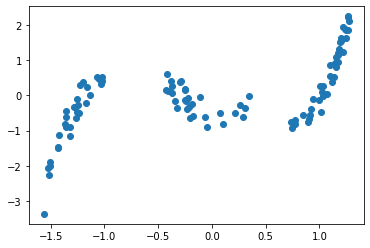

In [15]:
_ = plt.scatter(train_df_s[:,0], train_df_s[:,1], label='Training points')

In [16]:
pd.DataFrame(train_df_s).describe()

0             1
count  1.000000e+02  1.000000e+02
mean   1.054712e-17 -1.149081e-16
std    1.005038e+00  1.005038e+00
min   -1.560198e+00 -3.363658e+00
25%   -1.085137e+00 -5.882379e-01
50%   -1.425091e-01 -8.364310e-02
75%    1.032654e+00  4.613827e-01
max    1.271236e+00  2.238713e+00

In [17]:
pd.DataFrame(test_df_s).describe()

0           1
count  100.000000  100.000000
mean    -0.178520   -0.130238
std      0.837067    0.868963
min     -1.584240   -2.983195
25%     -0.935537   -0.535024
50%     -0.144725   -0.056941
75%      0.478700    0.481567
max      1.247584    1.796705

# Auxiliary functions

### Dataset and DataLoader

In [18]:
class PandasDataset(Dataset):

  def __init__(self, dataframe, transform=None):
    """
    Args:
        dataframe (pandas DataFrame): dataframe object.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    self.data = dataframe.values.tolist()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

In [19]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):

        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())
        
composed_transform = transforms.Compose([ToTensor()])

In [20]:
def MyDataLoader(train_df, train_index, test_index, train_batch_size, val_batch_size = False):
  
    train, val = train_df.iloc[train_index], train_df.iloc[test_index]

    train_dataset = PandasDataset(train, transform=composed_transform)
    val_dataset = PandasDataset(val, transform=composed_transform)

    if not val_batch_size: val_batch_size = len(val_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=0)
    val_dataloader   = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader

In [21]:
train_df_original = train_df.copy()
train_dataset_original = PandasDataset(train_df_original, transform=composed_transform)
train_dataloader_original = DataLoader(train_dataset_original, batch_size=18, shuffle=False, num_workers=0)

In [22]:
test_dataset = PandasDataset(test_df, transform=composed_transform)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)

### Network architecture

At the beginning I tried different things, also considering regularization techniques. Then, I discarded them, since they were not worth it.

In [23]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, activation, reg):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1) # fully connected 1
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2) # fully connected 2
        self.out = nn.Linear(in_features=Nh2, out_features=No) # output
        self.reg = reg
        if self.reg == 'Batch norm':
          self.reg1 = nn.BatchNorm1d(Nh1)
          self.reg2 = nn.BatchNorm1d(Nh2)
        elif self.reg == 'Dropout':
          self.reg1 = nn.Dropout(0.1)
          self.reg2 = nn.Dropout(0.1)
        self.act = activation # activation

        # print('Network initialized')
        
    def forward(self, x, additional_out=False):
        if self.reg:
            x = self.act(self.reg1(self.fc1(x)))
            x = self.act(self.reg2(self.fc2(x)))
            x = self.out(x)
        else: 
            x = self.act(self.fc1(x))
            x = self.act(self.fc2(x))
            x = self.out(x)

        return x

In [24]:
class Net5(nn.Module):
    
    def __init__(self, Ni, Nh, No, HL, activation, reg):
        """
        Ni - Input size
        Nh - Neurons in each hidden layer
        No - Output size
        HL - number of hidden layers (1<=HL<=5)
        """
        super().__init__()
        self.HL = HL
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh) # fully connected 1
        if self.HL >= 2: self.fc2 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 2
        if self.HL >= 3: self.fc3 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 3
        if self.HL >= 4: self.fc4 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 4
        if self.HL == 5: self.fc5 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 5
        self.out = nn.Linear(in_features=Nh, out_features=No) # output
        
        self.reg = reg
        if self.reg == 'Dropout':
            self.drop1 = nn.Dropout(0.1)
            if self.HL >= 2: self.drop2 = nn.Dropout(0.1)
            if self.HL >= 3: self.drop3 = nn.Dropout(0.1)
            if self.HL >= 4: self.drop4 = nn.Dropout(0.1)
            if self.HL == 5: self.drop5 = nn.Dropout(0.1)
        
        elif self.reg == 'Batch norm':
            self.batch1 = nn.BatchNorm1d(Nh)
            if self.HL >= 2: self.batch2 = nn.BatchNorm1d(Nh)
            if self.HL >= 3: self.batch3 = nn.BatchNorm1d(Nh)
            if self.HL >= 4: self.batch4 = nn.BatchNorm1d(Nh)
            if self.HL == 5: self.batch5 = nn.BatchNorm1d(Nh)

        self.act = activation # activation

    def forward(self, x, additional_out=False):
        if self.reg == 'Dropout':
            x = self.act(self.drop1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.drop2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.drop3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.drop4(self.fc4(x)))
            if self.HL == 5: x = self.act(self.drop5(self.fc5(x)))
            x = self.out(x)
        elif self.reg == 'Batch norm':
            x = self.act(self.batch1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.batch2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.batch3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.batch4(self.fc4(x)))
            if self.HL == 5: x = self.act(self.batch5(self.fc5(x)))
            x = self.out(x)
        else: 
            x = self.act(self.fc1(x))
            if self.HL >= 2: x = self.act(self.fc2(x))
            if self.HL >= 3: x = self.act(self.fc3(x))
            if self.HL >= 4: x = self.act(self.fc4(x))
            if self.HL == 5: x = self.act(self.fc5(x))
            x = self.out(x)

        return x

### Training Loop

In [25]:
def training_loop(net, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience = 200):
  ### TRAINING LOOP
  train_loss_log = []
  val_loss_log = []
  best_loss = 100

  # for epoch_num in tq.tqdm(range(num_epochs), desc = f'fold {fold + 1}'):
  for epoch_num in range(num_epochs):
    # print('#################')
    # print(f'# EPOCH {epoch_num}')
    # print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_function(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    # print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
    with torch.no_grad(): # Disable gradient tracking during validation
      for sample_batched in val_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_function(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      # print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)

    #   ### EARLY STOPPING
    #   if val_loss < best_loss:
    #     best_loss = val_loss # Update the best value so far
    #     corresponding_train_loss = train_loss
        
    #     # Save the network state
    #     best_net = net.state_dict()
    #     # Save the state dict to a file
    #     torch.save(best_net, 'best_net.torch')
        
    #     no_improve_epoch = 0 # Reset number of consecutive epochs without improvement
    #   else:
    #     no_improve_epoch += 1
    #     if no_improve_epoch == patience:
    #       break
  
  # Load the state dict previously saved
#   best_net = torch.load('best_net.torch')
  # Update the network parameters
#   net.load_state_dict(best_net)
  return train_loss_log, val_loss_log, train_loss, val_loss, net

In [26]:
def training_loop_final(net, train_dataloader, loss_function, optimizer, num_epochs, fold, patience = 200):
  ### TRAINING LOOP
  train_loss_log = []
  best_loss = 100

  # for epoch_num in tq.tqdm(range(num_epochs), desc = f'fold {fold + 1}'):
  for epoch_num in range(num_epochs):
    # print('#################')
    # print(f'# EPOCH {epoch_num}')
    # print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
    for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_function(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    # print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

      
  # Load the state dict previously saved
#   best_net = torch.load('best_net.torch')
  # Update the network parameters
#   net.load_state_dict(best_net)

  return train_loss_log, train_loss, net

### Plot losses

In [27]:
def plot_losses(train_loss_log, val_loss_log):
    plt.figure(figsize=(8,5))
    plt.semilogy(train_loss_log, label='Train loss')
    plt.semilogy(val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

### Plot model approximation

In [28]:
def printFinalModel(net):
    
    train = train_df
    
    # Network output
    x_train = torch.Tensor(train.input)
    x_train = x_train.to(device)
    x_train = x_train.unsqueeze(-1) # because in our network there is an axis for the batch size

    # x_val = torch.Tensor(val.input)
    # x_val = x_val.to(device)
    # x_val = x_val.unsqueeze(-1) # because in our network there is an axis for the batch size

    x_vec = torch.linspace(-5,5,100)
    x_vec = x_vec.to(device)
    x_vec = x_vec.unsqueeze(-1)

    net.eval()
    with torch.no_grad():
      y_train_pred = net(x_train)
    #   y_val_pred = net(x_val)
      y_vec = net(x_vec)

    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_train = x_train.squeeze().cpu().numpy()
    # x_val = x_val.squeeze().cpu().numpy()
    x_vec = x_vec.squeeze().cpu().numpy()
    y_train_pred = y_train_pred.squeeze().cpu().numpy()
    # y_val_pred = y_val_pred.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    plt.figure(figsize=(8,5))
    plt.plot(x_vec, y_vec, label='Network approximation', color = 'red')
    plt.scatter(x_train, train.label, label='Training set', color = 'blue')
    # plt.scatter(x_val, val.label, label='Validation set', color = 'green')
    plt.scatter(x_train, y_train_pred, label='Predictions train', color = 'orange')
    # plt.scatter(x_val, y_val_pred, label='Predictions val', color = 'green')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.legend()
    plt.show()

### Activation functions

In this section I just explore different activation functions

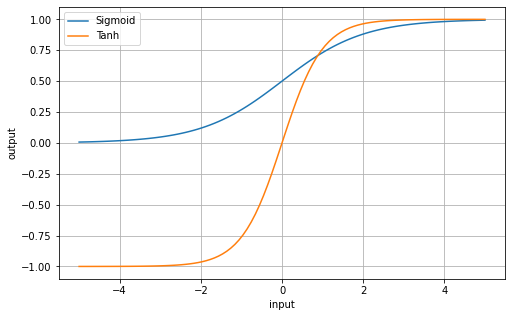

In [31]:
xxx = torch.linspace(-5,5,100)

sig = nn.Sigmoid()
sig_act = sig(xxx)

tan = nn.Tanh()
tan_act = tan(xxx)

# Plot output
plt.figure(figsize=(8,5))
plt.plot(xxx, sig_act, label='Sigmoid')
plt.plot(xxx, tan_act, label='Tanh')
plt.xlabel('input')
plt.ylabel('output')
plt.grid()
plt.legend()
plt.show()

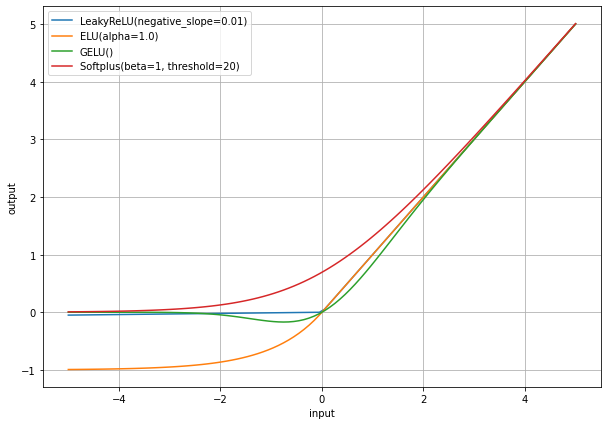

In [32]:
xxx = torch.linspace(-5,5,100)

activation_vector = [nn.LeakyReLU(), nn.ELU(), nn.GELU(), nn.Softplus()]

# Plot output
plt.figure(figsize=(10,7))
for activ in activation_vector:
    activated = activ(xxx)
    plt.plot(xxx, activated, label=f'{activ}')
plt.xlabel('input')
plt.ylabel('output')
plt.grid()
plt.legend()
plt.show()

# Model optimization: grid-search & cross-validation

I decided to use 10 folds cv since the dataset is very small. This allows to use 90 sample at a time, at the cost of reducing the evaluation capacity in the validation set (which has only 10 samples). 

In what follows, I will perform a grid search focusing on the most important parameter of the network architecture: number of layers, hidden neurons and activation functions. Moreover, I will try different learning rates.

### Hidden neurons 16, 32 or 64


Training the Network with 2 hidden layers of 16 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.36886, Avg val loss: 0.44489


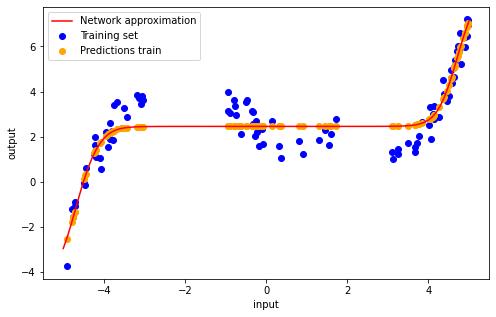

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 2.38589, Avg val loss: 2.49085


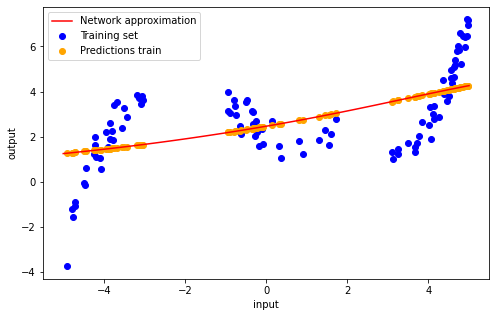

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.25764, Avg val loss: 0.32029


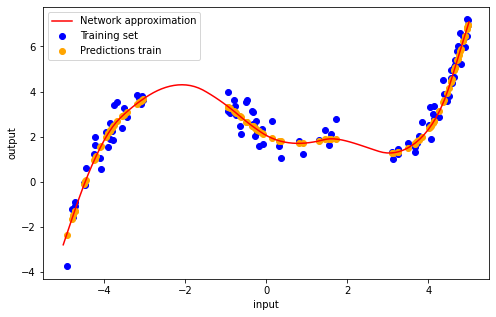

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.77089, Avg val loss: 0.86371


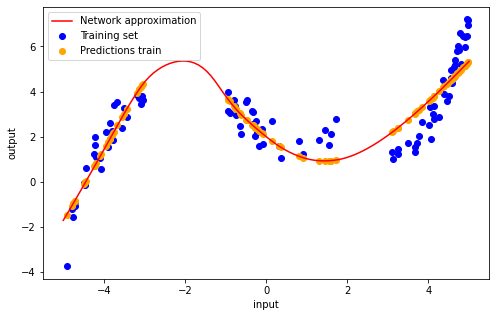

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.22648, Avg val loss: 0.27807


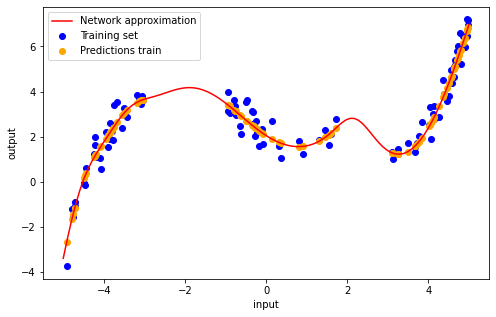

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.43056, Avg val loss: 0.50356


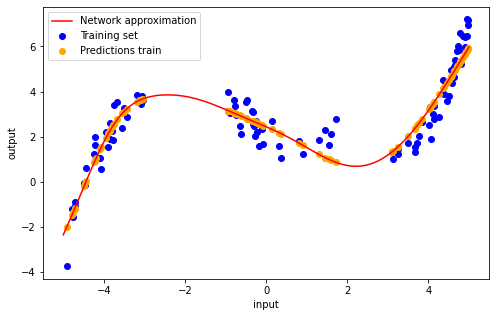

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.22158, Avg val loss: 0.29410


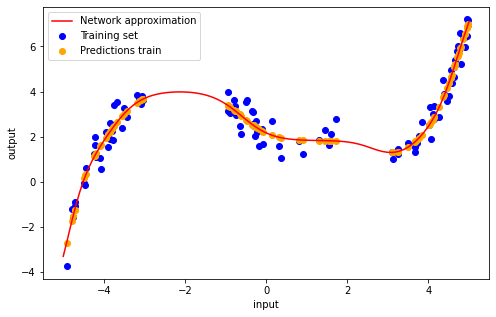

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 2.26363, Avg val loss: 2.39624


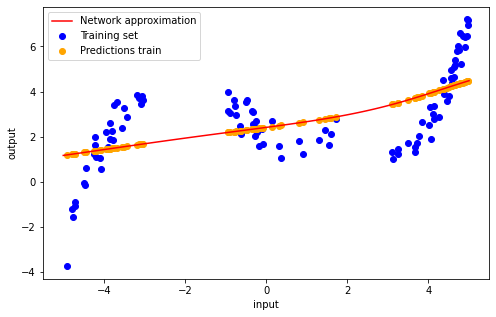

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.23942, Avg val loss: 0.31282


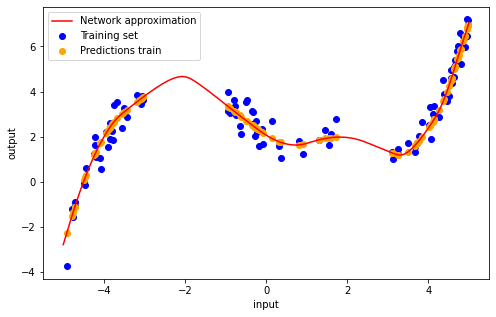

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.28605, Avg val loss: 0.33627


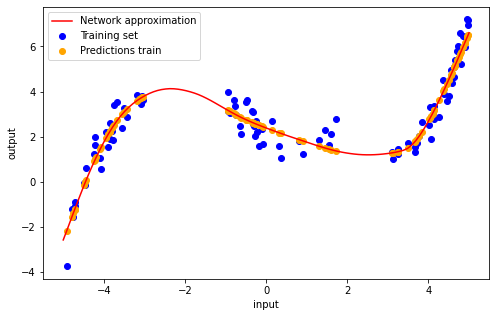

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21523, Avg val loss: 0.28831


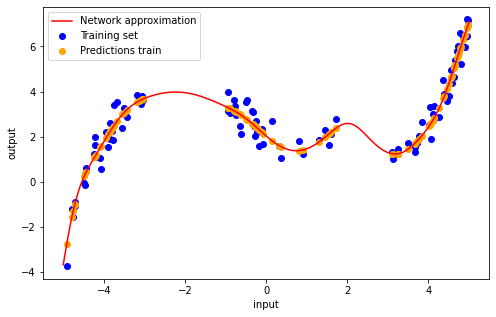

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.24046, Avg val loss: 0.29493


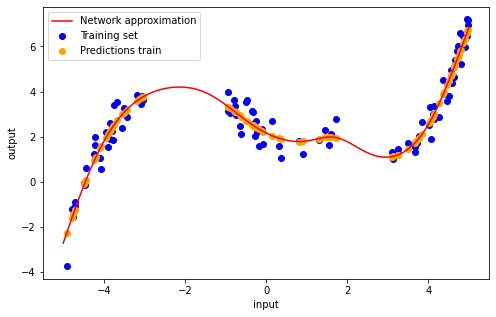

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.21109, Avg val loss: 0.28088


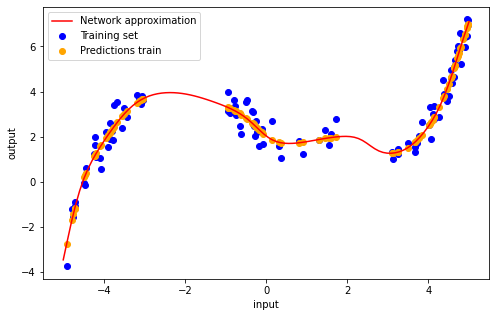

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 1.12577, Avg val loss: 1.31606


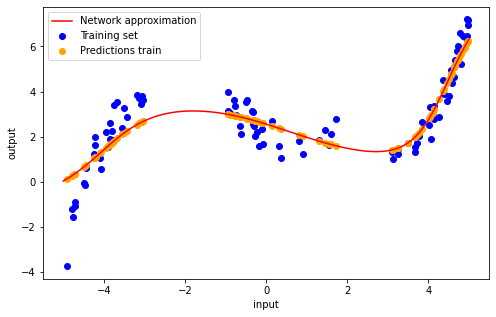

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.24509, Avg val loss: 0.31903


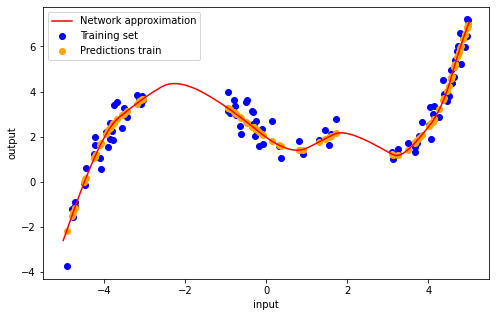

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.24297, Avg val loss: 0.29349


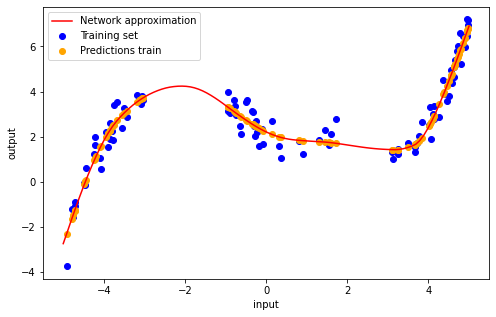

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21618, Avg val loss: 0.28688


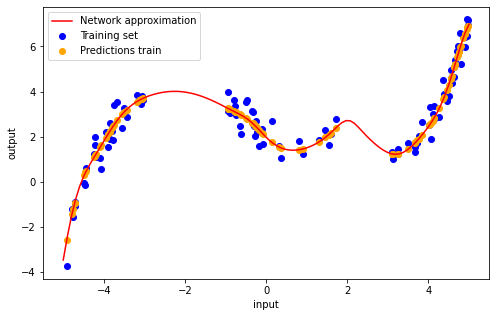

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.21422, Avg val loss: 0.27893


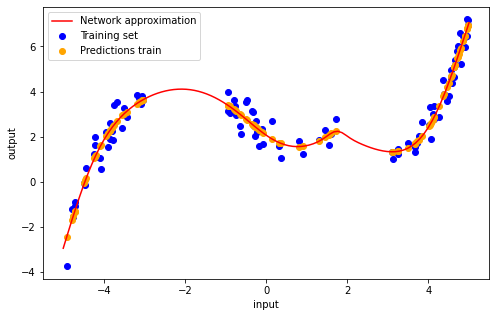

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.24837, Avg val loss: 0.32156


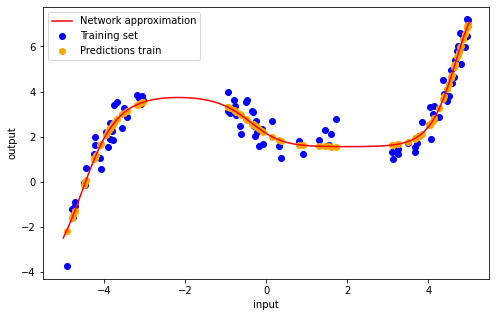

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 2.01988, Avg val loss: 2.10504


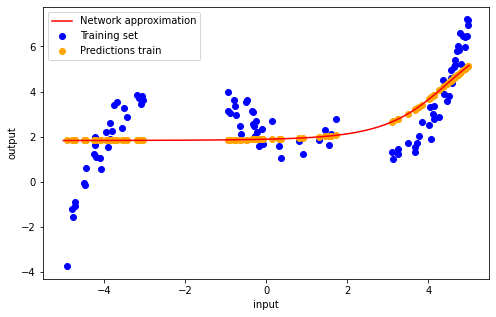

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.23355, Avg val loss: 0.29165


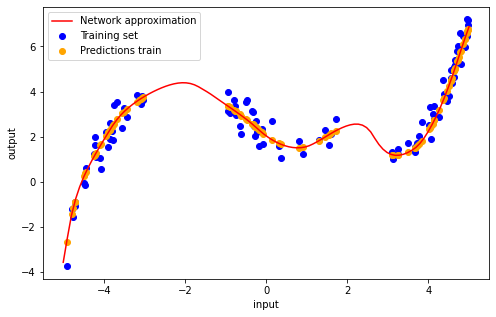

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.41931, Avg val loss: 0.47479


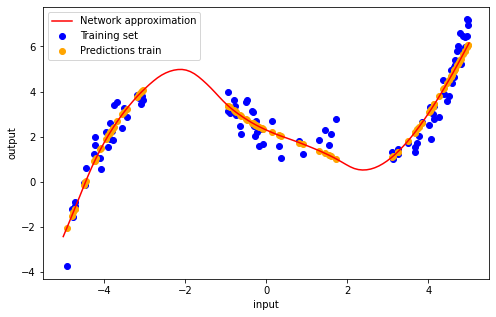

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21400, Avg val loss: 0.28629


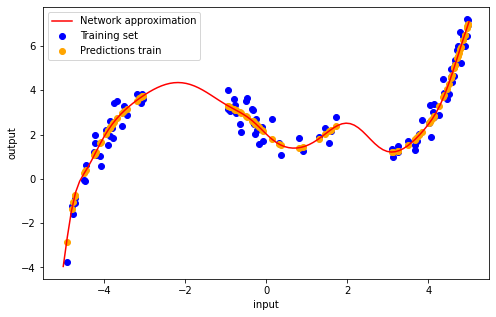

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.24928, Avg val loss: 0.30002


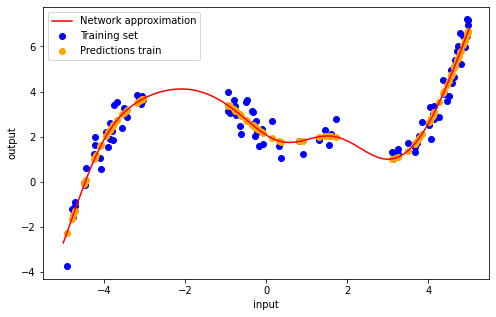

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.21775, Avg val loss: 0.29198


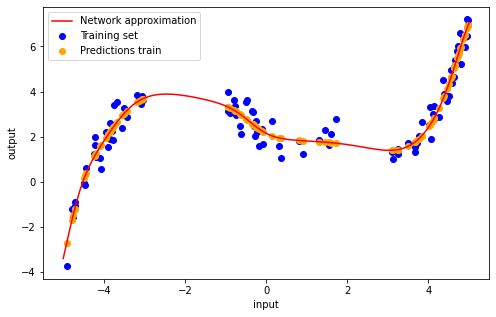

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 1.48073, Avg val loss: 1.54208


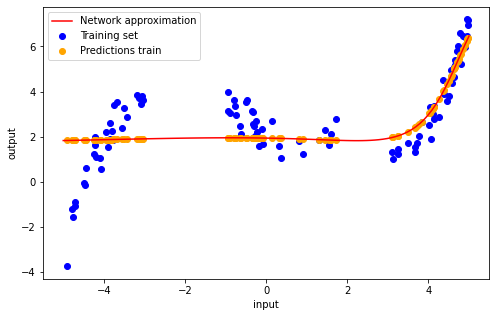

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.21813, Avg val loss: 0.29270


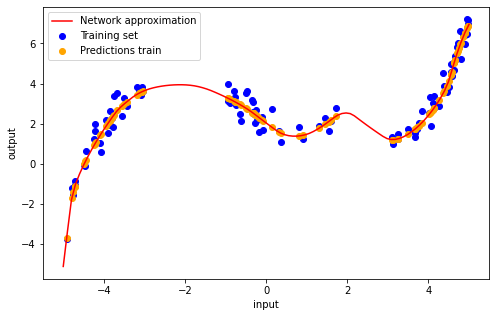

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.22088, Avg val loss: 0.28212


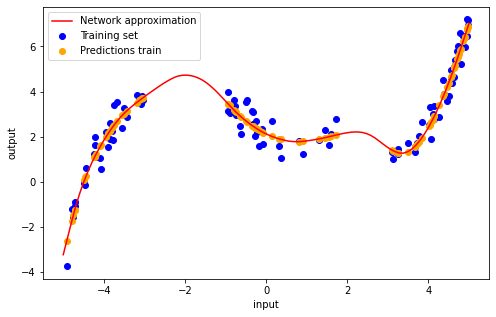

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21591, Avg val loss: 0.31892


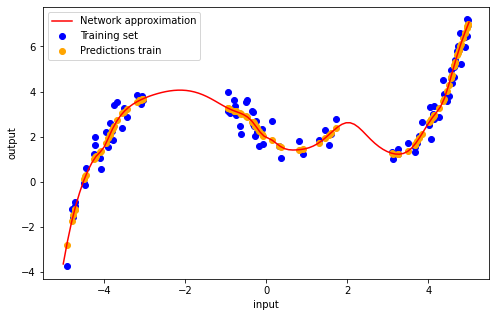

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.21313, Avg val loss: 0.27287


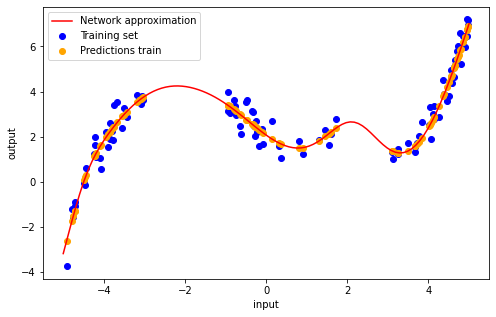

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.22051, Avg val loss: 0.28634


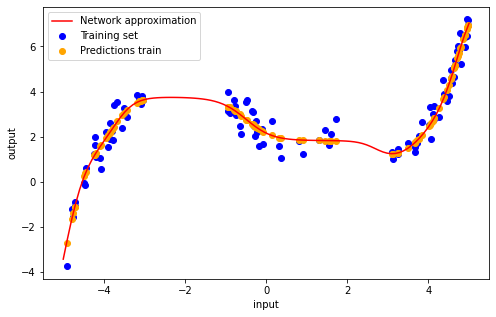

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 0.72936, Avg val loss: 0.96099


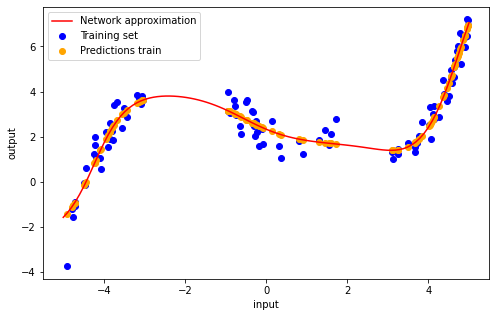

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.25835, Avg val loss: 0.32528


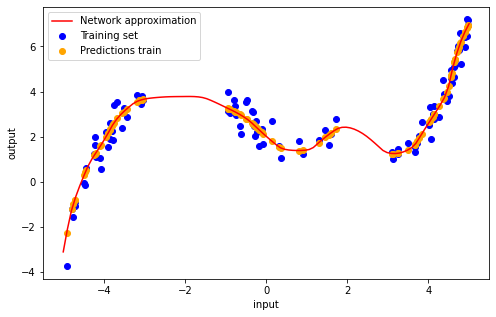

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.21909, Avg val loss: 0.26482


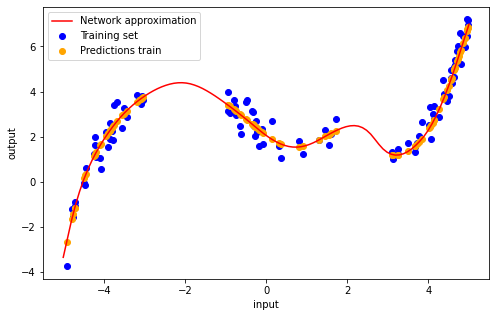

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21680, Avg val loss: 0.32842


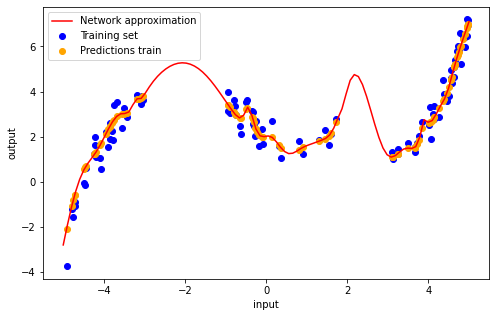

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.21819, Avg val loss: 0.27874


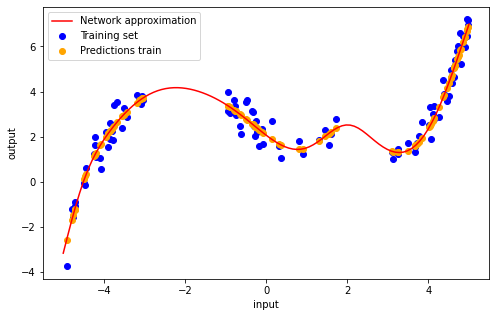

###############################################################################



In [ ]:
# hidden neurons 16, 32, 64

torch.manual_seed(1)
np.random.seed(0)

# K-FOLDS CROSS-VALIDATION
kf = KFold(n_splits=10, shuffle=True, random_state=0)

num_epochs = 500
patience = 500

# Network parameters
Ni = 1
No = 1

# GRID-SEARCH
HL_vector = [2, 3]
Nh_vector = [16, 32, 64]
activation_vector = [nn.Sigmoid(), nn.ELU(), nn.GELU()]
# # GELU: smooth ReLU
lr_vector = [0.01, 0.001]

# Nh_vector = [16]
# activation_vector = [nn.Sigmoid()]
# lr_vector = [0.01]

results = []

for (HL, Nh, act, lr) in tq.tqdm(list(itertools.product(HL_vector, 
                                                        Nh_vector, 
                                                        activation_vector,
                                                        lr_vector)),
                                 desc = 'GRID SEARCH PROGRESS'):
  
    print(f'\nTraining the Network with {HL} hidden layers of {Nh} neurons, act = {act} and lr = {lr}')

    train_loss_vec = []
    val_loss_vec = []
    

    for fold, (train_index, test_index) in enumerate(tq.tqdm(kf.split(train_df), 
                                                             desc = f'CV',
                                                             total = 10)):

        # DATASET AND DATALOADER
        train_dataloader, val_dataloader = MyDataLoader(train_df, train_index, test_index, train_batch_size = 18)

        # NETWORK INITIALIZATION
        torch.manual_seed(0)
        net = Net5(Ni, Nh, No, HL, act, reg=False)
        net.to(device)

        # Define the loss function
        loss_function = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        # TRAINING LOOP
        train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                    train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
        train_loss_vec.append(train_loss), val_loss_vec.append(val_loss)

        # if fold == 0:
        #     # Plot losses
        #     plot_losses(train_loss_log, val_loss_log)

        #     printModel(net)

            # print('------------------------------------------------------------------------------')   

    #     printModel(net)

    mean_train_loss = np.mean(train_loss_vec)
    mean_val_loss = np.mean(val_loss_vec)

    k = f'{HL} hidden layers, {Nh} neurons, act = {act} and lr = {lr}'
    results.append((k, mean_val_loss))

    print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 

    
    # --- Full training ---

    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                          fold, patience = 1000)
    
    # Print model
    printFinalModel(net)

    # print(f'Average validation loss: {np.mean(val_loss_vec):.5f}') 
    print('###############################################################################')

In [ ]:
results_sorted = sorted(results, key=lambda tup: tup[1])
results_sorted

[('3 hidden layers, 64 neurons, act = ELU(alpha=1.0) and lr = 0.001',
  0.26481745),
 ('3 hidden layers, 32 neurons, act = GELU() and lr = 0.001', 0.2728706),
 ('2 hidden layers, 16 neurons, act = GELU() and lr = 0.01', 0.27806622),
 ('3 hidden layers, 64 neurons, act = GELU() and lr = 0.001', 0.2787432),
 ('2 hidden layers, 64 neurons, act = GELU() and lr = 0.001', 0.2789324),
 ('2 hidden layers, 64 neurons, act = Sigmoid() and lr = 0.01', 0.28087538),
 ('3 hidden layers, 32 neurons, act = ELU(alpha=1.0) and lr = 0.001',
  0.28212136),
 ('3 hidden layers, 16 neurons, act = GELU() and lr = 0.01', 0.2862938),
 ('3 hidden layers, 64 neurons, act = Sigmoid() and lr = 0.01', 0.286341),
 ('2 hidden layers, 64 neurons, act = GELU() and lr = 0.01', 0.28687632),
 ('2 hidden layers, 32 neurons, act = GELU() and lr = 0.01', 0.28831),
 ('3 hidden layers, 16 neurons, act = ELU(alpha=1.0) and lr = 0.01',
  0.29165348),
 ('3 hidden layers, 32 neurons, act = Sigmoid() and lr = 0.01', 0.29198354),
 ('

### Hidden neurons 128 or 256


Training the Network with 2 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.21849, Avg val loss: 0.29633


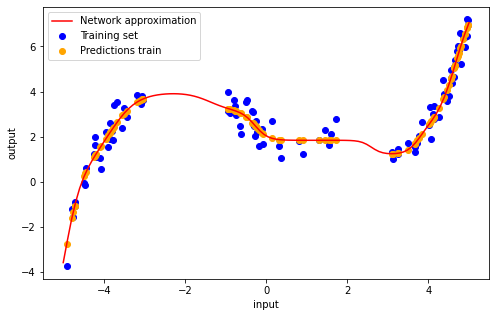

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 0.35117, Avg val loss: 0.49469


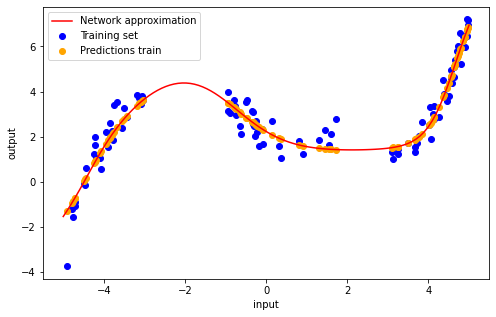

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.0001



Avg train loss: 2.55708, Avg val loss: 2.64869


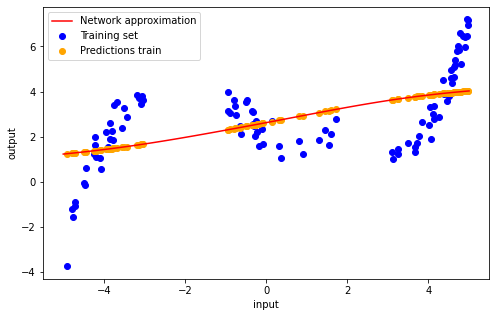

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.30448, Avg val loss: 0.39775


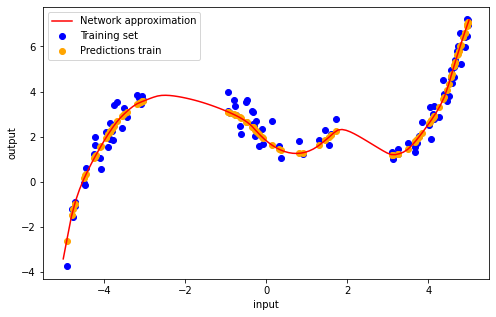

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.23383, Avg val loss: 0.29195


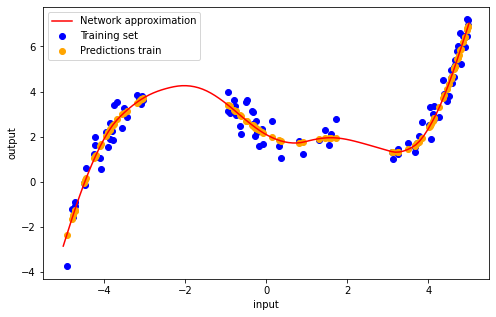

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.0001



Avg train loss: 0.81148, Avg val loss: 0.90841


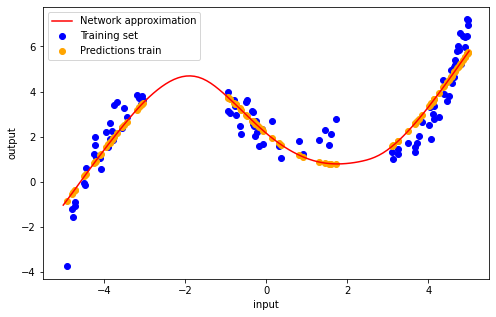

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.22307, Avg val loss: 0.30417


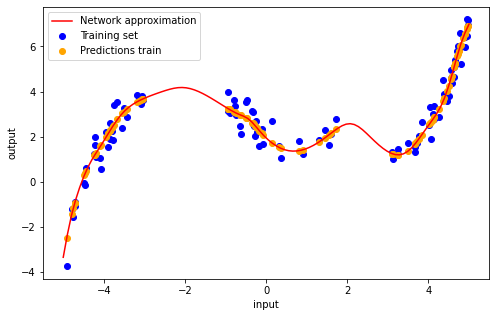

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.22109, Avg val loss: 0.28766


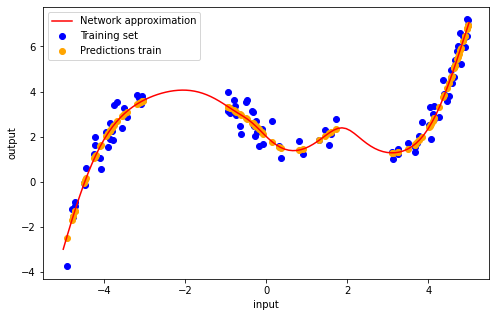

###############################################################################

Training the Network with 2 hidden layers of 128 neurons, act = GELU() and lr = 0.0001



Avg train loss: 0.46401, Avg val loss: 0.52915


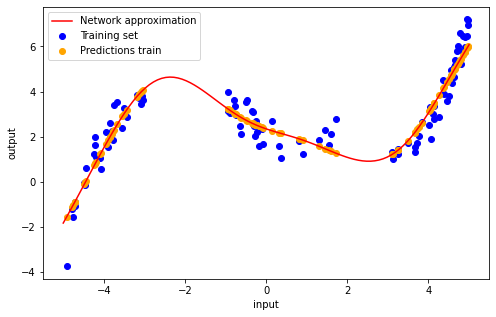

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.22009, Avg val loss: 0.28961


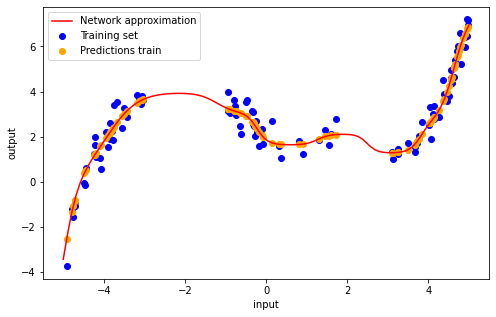

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 0.25838, Avg val loss: 0.31928


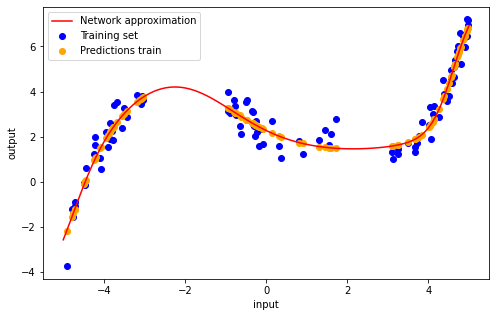

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.0001



Avg train loss: 2.30083, Avg val loss: 2.40966


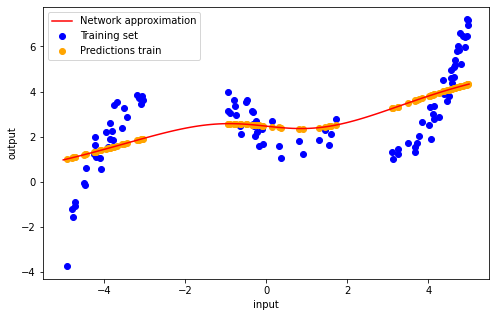

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.27370, Avg val loss: 0.29298


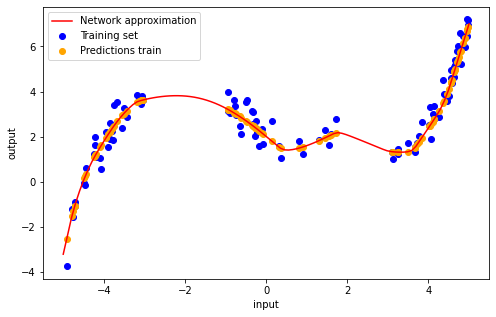

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.24983, Avg val loss: 0.30294


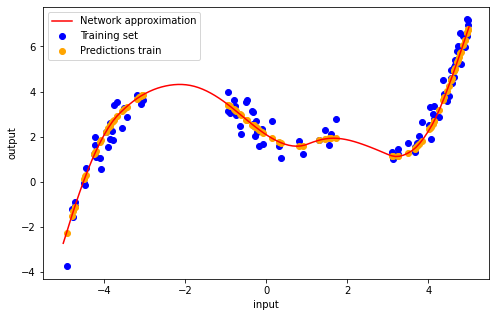

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.0001



Avg train loss: 0.45105, Avg val loss: 0.51908


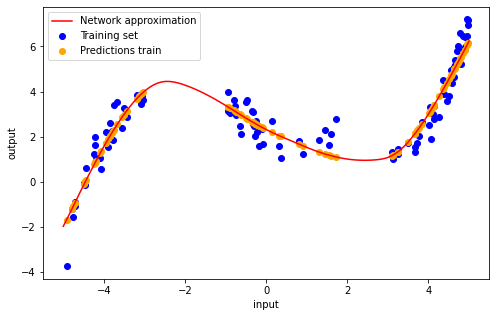

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.22994, Avg val loss: 0.30659


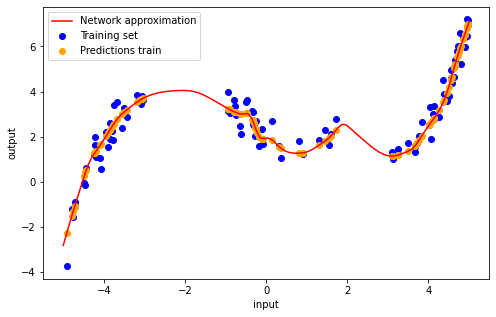

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.22245, Avg val loss: 0.29433


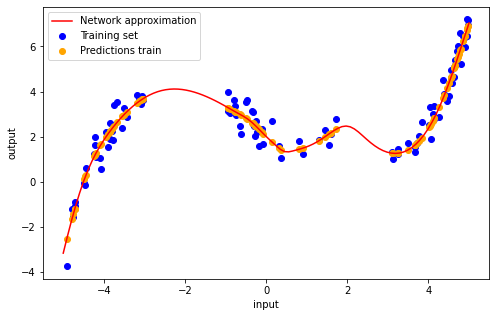

###############################################################################

Training the Network with 2 hidden layers of 256 neurons, act = GELU() and lr = 0.0001



Avg train loss: 0.28083, Avg val loss: 0.32749


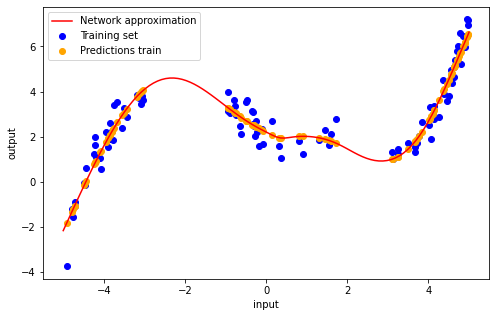

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.23624, Avg val loss: 0.32215


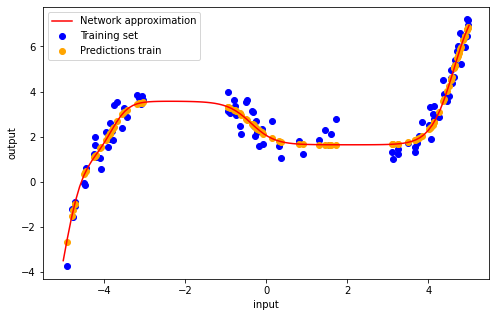

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 0.24734, Avg val loss: 0.30079


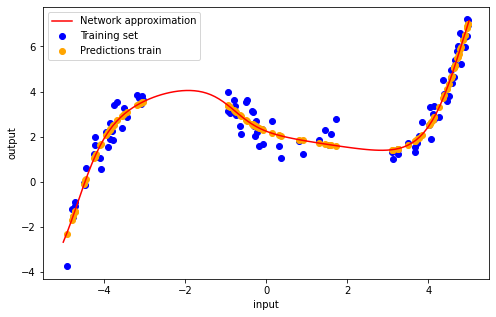

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = Sigmoid() and lr = 0.0001



Avg train loss: 2.52862, Avg val loss: 2.62923


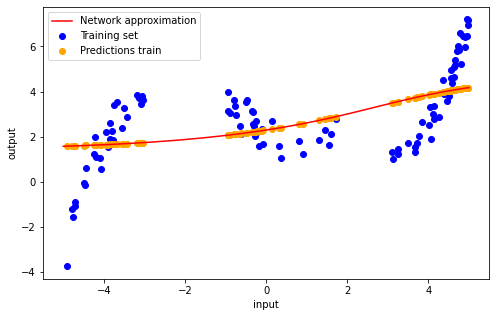

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.24592, Avg val loss: 0.30256


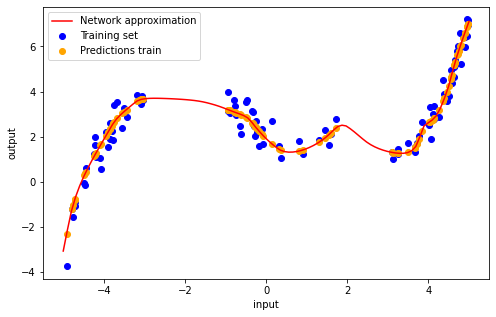

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.22316, Avg val loss: 0.27288


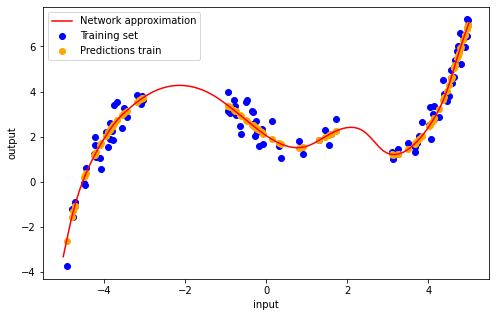

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = ELU(alpha=1.0) and lr = 0.0001



Avg train loss: 0.32684, Avg val loss: 0.37534


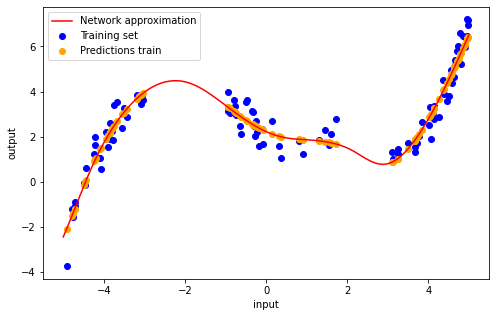

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.18765, Avg val loss: 0.30001


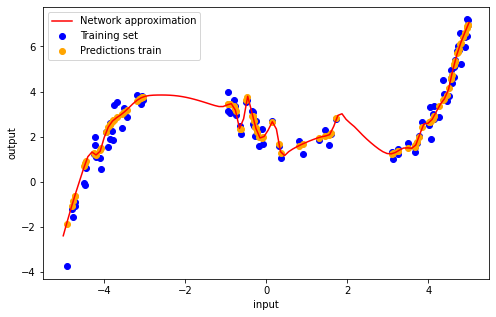

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.21883, Avg val loss: 0.28146


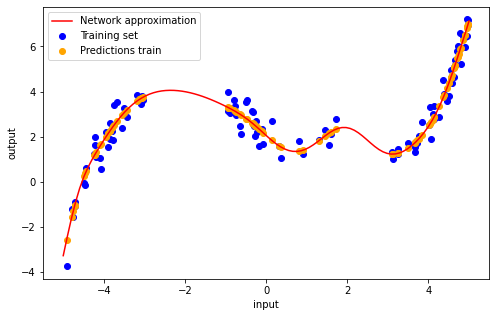

###############################################################################

Training the Network with 3 hidden layers of 128 neurons, act = GELU() and lr = 0.0001



Avg train loss: 0.25236, Avg val loss: 0.30150


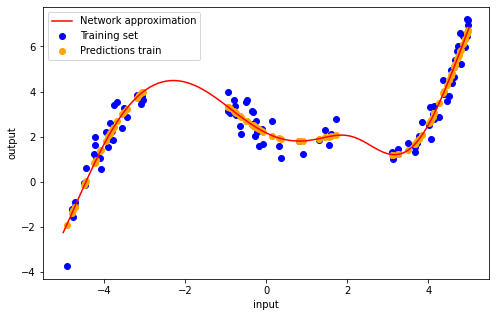

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.01



Avg train loss: 0.57945, Avg val loss: 0.97857


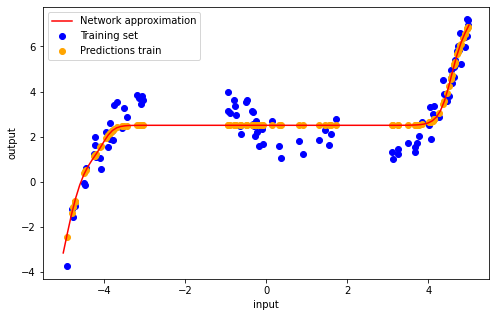

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.001



Avg train loss: 0.21720, Avg val loss: 0.28368


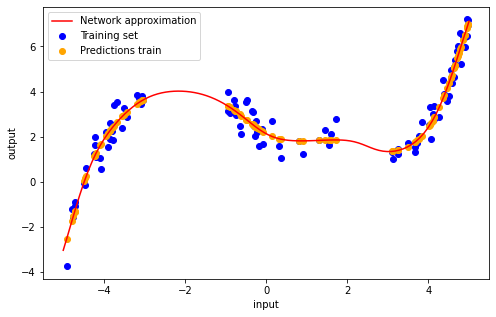

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = Sigmoid() and lr = 0.0001



Avg train loss: 2.02118, Avg val loss: 2.15494


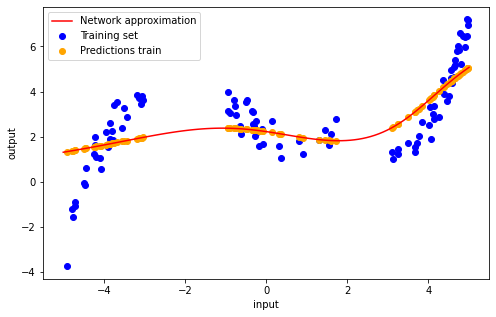

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.01



Avg train loss: 0.29030, Avg val loss: 0.41703


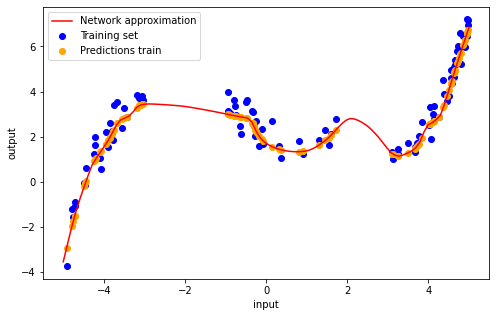

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.001



Avg train loss: 0.22948, Avg val loss: 0.29143


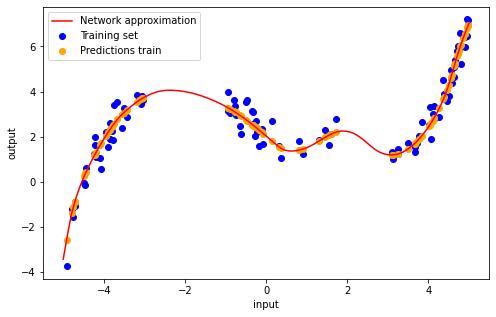

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = ELU(alpha=1.0) and lr = 0.0001



Avg train loss: 0.23394, Avg val loss: 0.28417


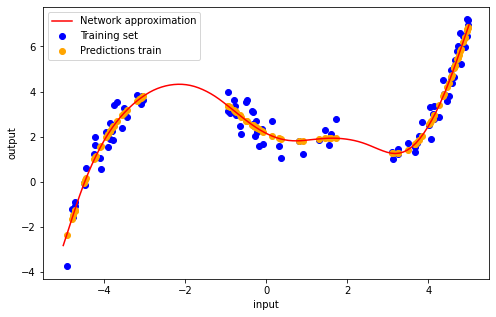

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = GELU() and lr = 0.01



Avg train loss: 0.21511, Avg val loss: 0.36632


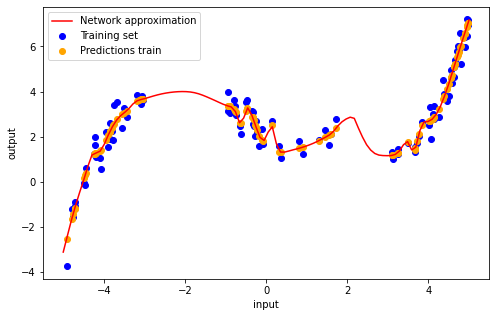

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = GELU() and lr = 0.001



Avg train loss: 0.21748, Avg val loss: 0.27854


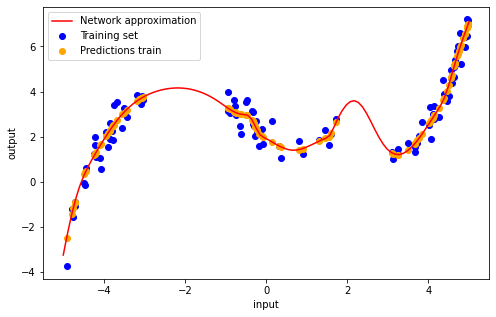

###############################################################################

Training the Network with 3 hidden layers of 256 neurons, act = GELU() and lr = 0.0001



Avg train loss: 0.22771, Avg val loss: 0.28350


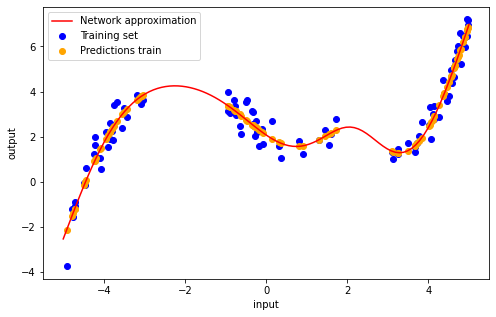

###############################################################################



In [ ]:
# hidden neurons 128 or 256

torch.manual_seed(1)
np.random.seed(0)

# K-FOLDS CROSS-VALIDATION
kf = KFold(n_splits=10, shuffle=True, random_state=0)

num_epochs = 500
patience = 500

# Network parameters
Ni = 1
No = 1

# GRID-SEARCH
HL_vector = [2, 3]
Nh_vector = [128, 256]
activation_vector = [nn.Sigmoid(), nn.ELU(), nn.GELU()]
# # GELU: smooth ReLU
lr_vector = [0.01, 0.001, 0.0001]

# Nh_vector = [16]
# activation_vector = [nn.Sigmoid()]
# lr_vector = [0.01]

results = []

for (HL, Nh, act, lr) in tq.tqdm(list(itertools.product(HL_vector, 
                                                        Nh_vector, 
                                                        activation_vector,
                                                        lr_vector)),
                                 desc = 'GRID SEARCH PROGRESS'):
  
    print(f'\nTraining the Network with {HL} hidden layers of {Nh} neurons, act = {act} and lr = {lr}')

    train_loss_vec = []
    val_loss_vec = []
    

    for fold, (train_index, test_index) in enumerate(tq.tqdm(kf.split(train_df), 
                                                             desc = f'CV',
                                                             total = 10)):

        # DATASET AND DATALOADER
        train_dataloader, val_dataloader = MyDataLoader(train_df, train_index, test_index, train_batch_size = 18)

        # NETWORK INITIALIZATION
        torch.manual_seed(0)
        net = Net5(Ni, Nh, No, HL, act, reg=False)
        net.to(device)

        # Define the loss function
        loss_function = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        # TRAINING LOOP
        train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                    train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
        train_loss_vec.append(train_loss), val_loss_vec.append(val_loss)

        # if fold == 0:
        #     # Plot losses
        #     plot_losses(train_loss_log, val_loss_log)

        #     printModel(net)

            # print('------------------------------------------------------------------------------')   

    #     printModel(net)

    mean_train_loss = np.mean(train_loss_vec)
    mean_val_loss = np.mean(val_loss_vec)

    k = f'{HL} hidden layers, {Nh} neurons, act = {act} and lr = {lr}'
    results.append((k, mean_val_loss))

    print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 

    
    # --- Full training ---

    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)    

    train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                          fold, patience = 1000)
    
    # Print model
    printFinalModel(net)

    # print(f'Average validation loss: {np.mean(val_loss_vec):.5f}') 
    print('###############################################################################')

In [ ]:
results_sorted = sorted(results, key=lambda tup: tup[1])
results_sorted

[('3 hidden layers, 128 neurons, act = ELU(alpha=1.0) and lr = 0.001',
  0.2728767),
 ('3 hidden layers, 256 neurons, act = GELU() and lr = 0.001', 0.2785432),
 ('3 hidden layers, 128 neurons, act = GELU() and lr = 0.001', 0.281458),
 ('3 hidden layers, 256 neurons, act = GELU() and lr = 0.0001', 0.28350493),
 ('3 hidden layers, 256 neurons, act = Sigmoid() and lr = 0.001', 0.2836823),
 ('3 hidden layers, 256 neurons, act = ELU(alpha=1.0) and lr = 0.0001',
  0.28417277),
 ('2 hidden layers, 128 neurons, act = GELU() and lr = 0.001', 0.28765923),
 ('2 hidden layers, 256 neurons, act = Sigmoid() and lr = 0.01', 0.2896054),
 ('3 hidden layers, 256 neurons, act = ELU(alpha=1.0) and lr = 0.001',
  0.29143286),
 ('2 hidden layers, 128 neurons, act = ELU(alpha=1.0) and lr = 0.001',
  0.29195195),
 ('2 hidden layers, 256 neurons, act = ELU(alpha=1.0) and lr = 0.01',
  0.29297668),
 ('2 hidden layers, 256 neurons, act = GELU() and lr = 0.001', 0.29433033),
 ('2 hidden layers, 128 neurons, act =

### Considering other activation functions



Training the Network with 2 hidden layers of 16 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.22340, Avg val loss: 0.30839


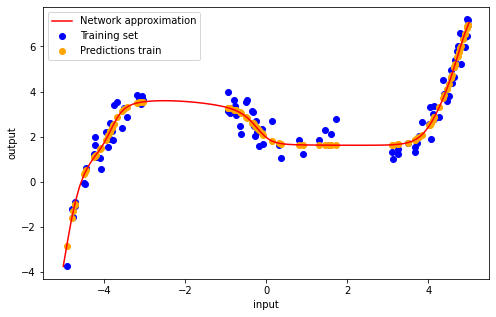

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.43691, Avg val loss: 0.51969


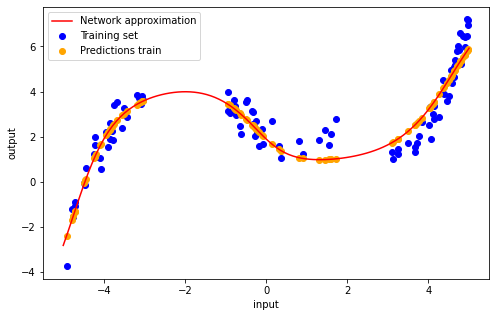

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.23669, Avg val loss: 0.31673


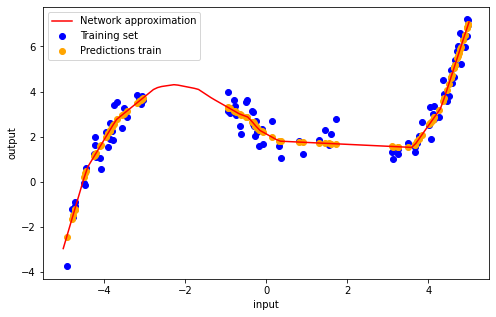

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.58977, Avg val loss: 0.69215


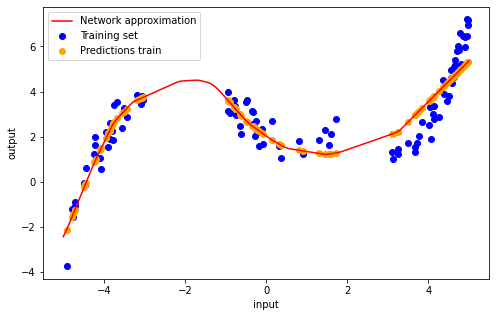

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.23893, Avg val loss: 0.30007


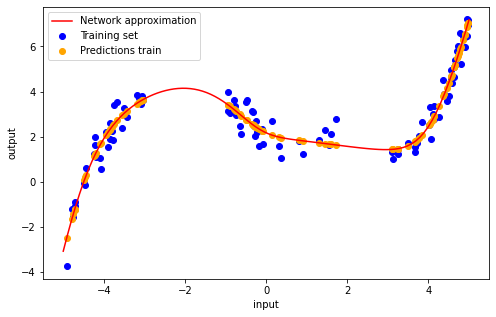

###############################################################################

Training the Network with 2 hidden layers of 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.69683, Avg val loss: 0.80380


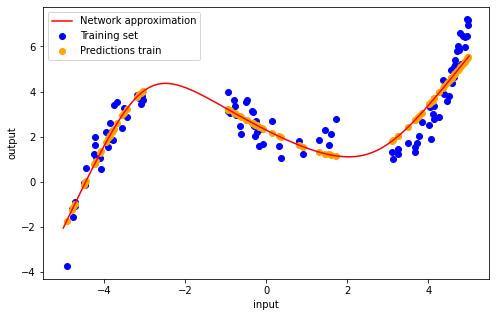

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.20054, Avg val loss: 0.28977


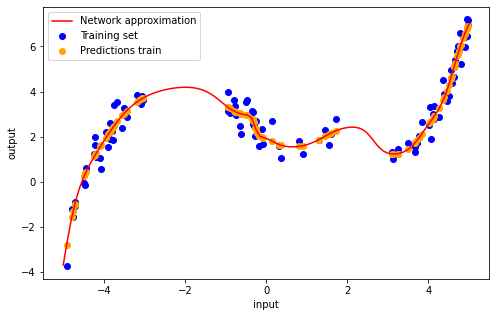

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.25621, Avg val loss: 0.31396


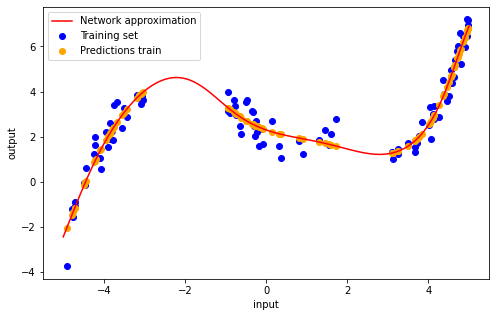

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.22088, Avg val loss: 0.31702


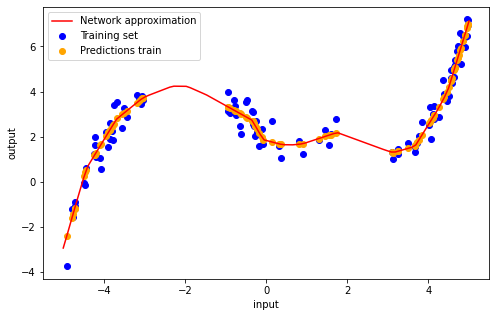

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.31356, Avg val loss: 0.38724


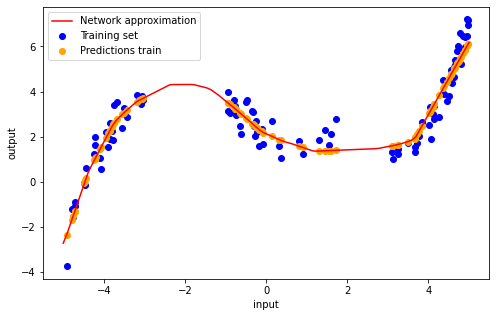

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.24035, Avg val loss: 0.30720


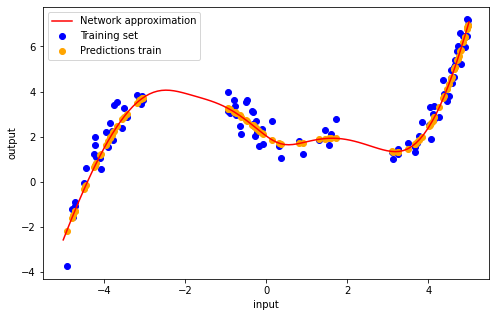

###############################################################################

Training the Network with 2 hidden layers of 32 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.35440, Avg val loss: 0.40212


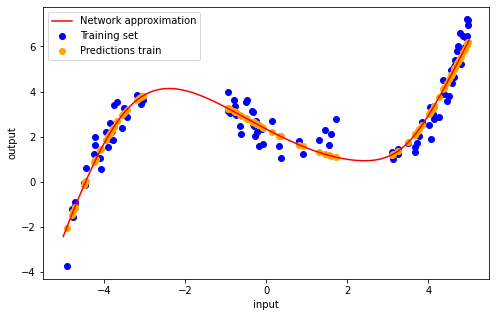

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.18357, Avg val loss: 0.29465


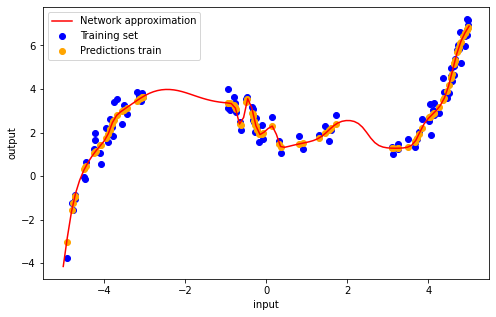

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.23102, Avg val loss: 0.29287


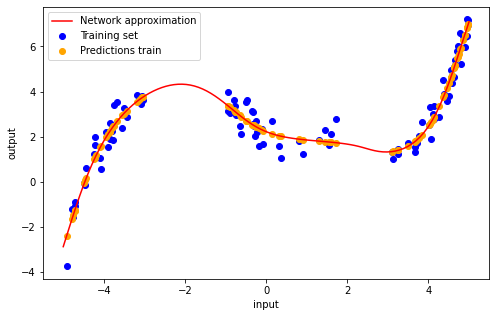

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.20290, Avg val loss: 0.30379


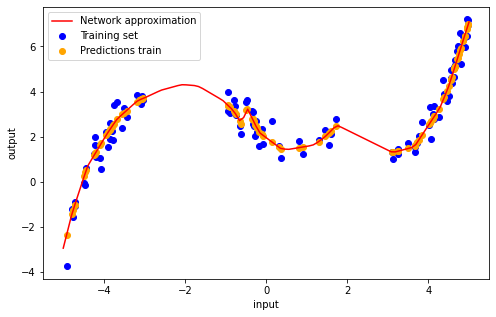

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.21735, Avg val loss: 0.30882


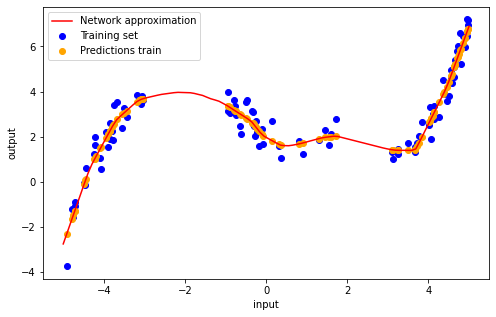

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.24542, Avg val loss: 0.31779


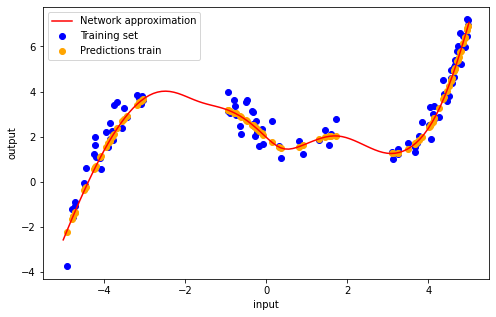

###############################################################################

Training the Network with 2 hidden layers of 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.28052, Avg val loss: 0.32065


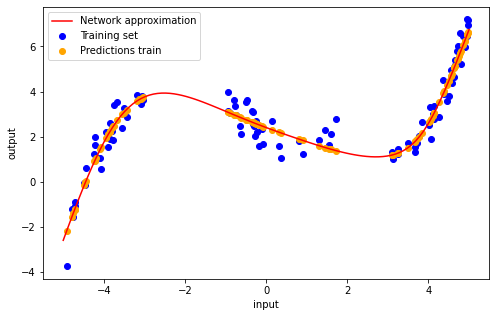

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.28284, Avg val loss: 0.35339


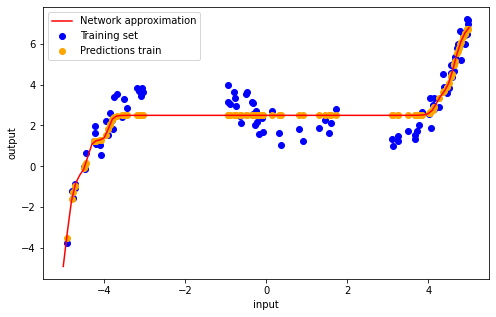

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.23914, Avg val loss: 0.30404


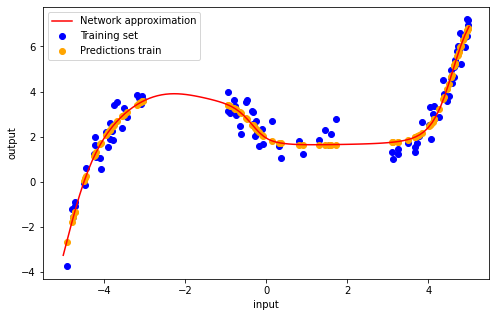

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.23555, Avg val loss: 0.32761


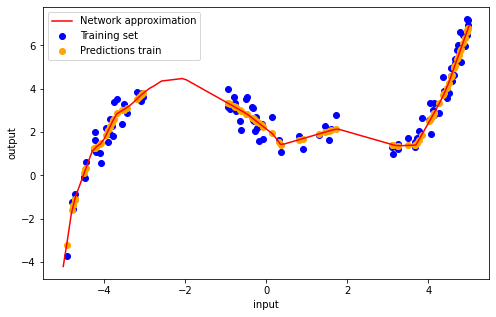

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.31826, Avg val loss: 0.42544


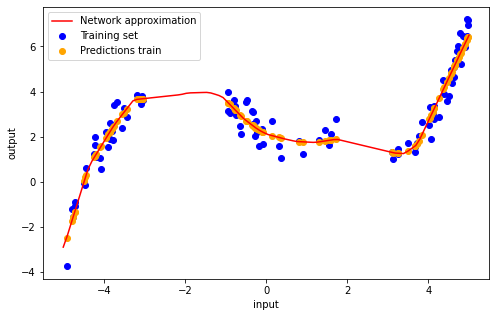

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.23496, Avg val loss: 0.29081


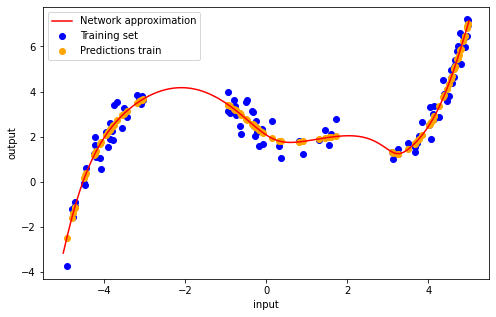

###############################################################################

Training the Network with 3 hidden layers of 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.68422, Avg val loss: 0.86619


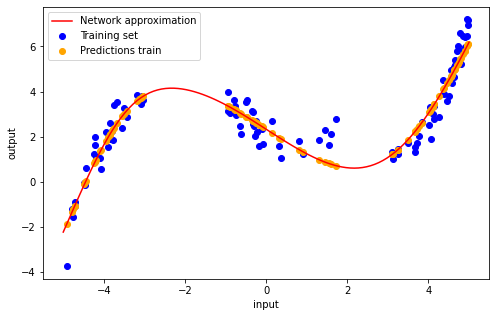

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.21054, Avg val loss: 0.31924


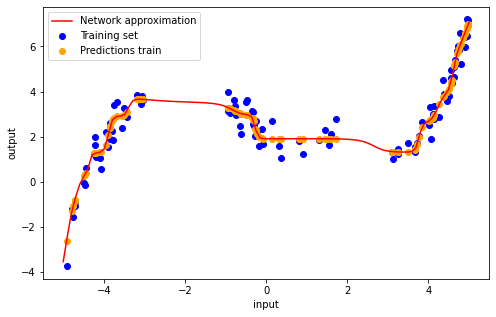

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.23208, Avg val loss: 0.29496


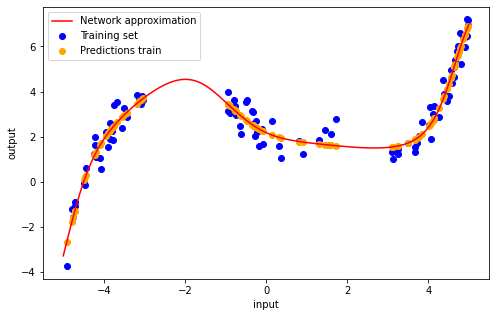

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.21515, Avg val loss: 0.36333


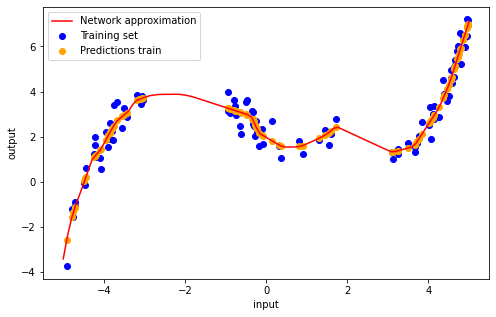

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.20111, Avg val loss: 0.29110


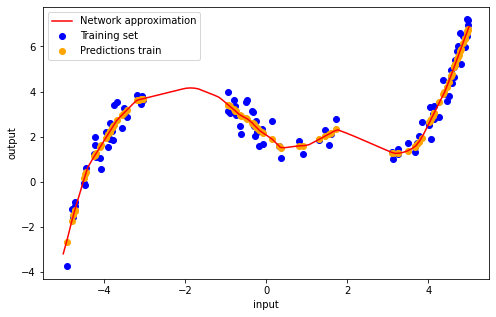

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.23177, Avg val loss: 0.28664


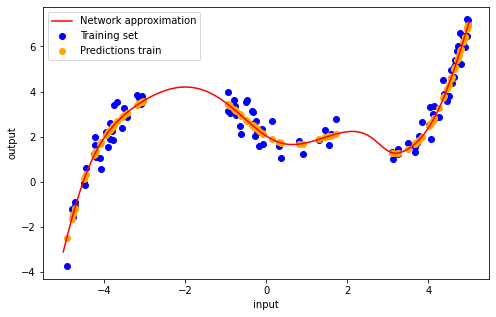

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.26970, Avg val loss: 0.31198


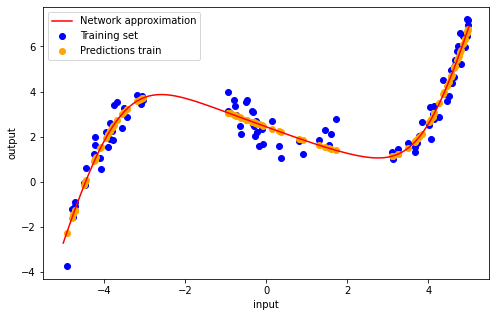

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Tanh() and lr = 0.01



Avg train loss: 0.22930, Avg val loss: 0.37564


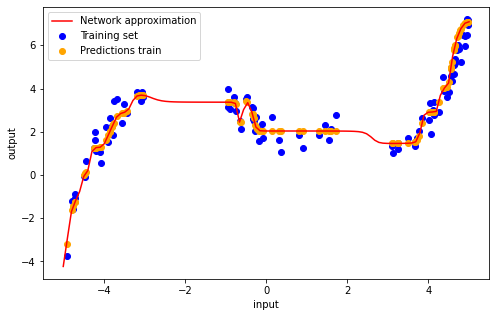

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Tanh() and lr = 0.001



Avg train loss: 0.22311, Avg val loss: 0.28381


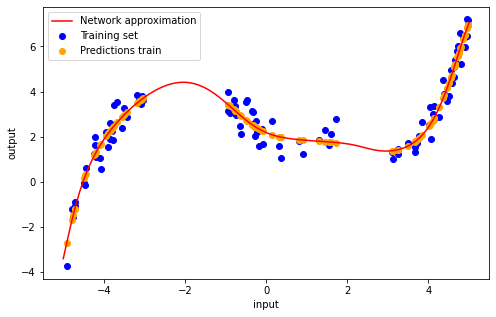

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.01



Avg train loss: 0.20987, Avg val loss: 0.35122


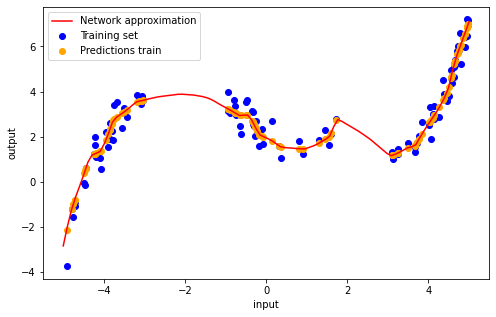

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001



Avg train loss: 0.19725, Avg val loss: 0.32059


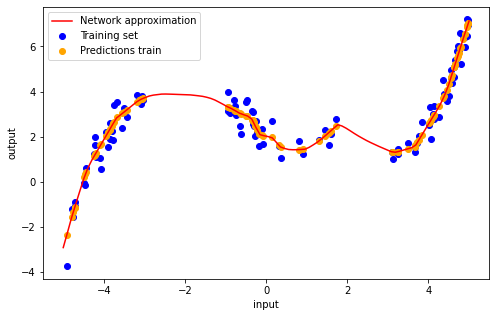

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01



Avg train loss: 0.24347, Avg val loss: 0.29483


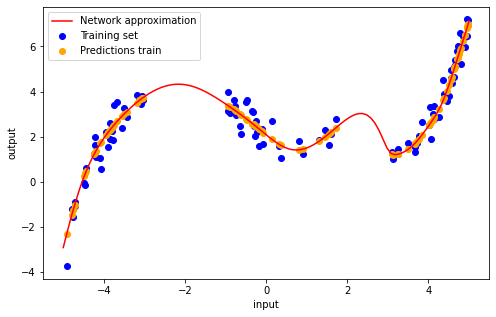

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001



Avg train loss: 0.23992, Avg val loss: 0.28497


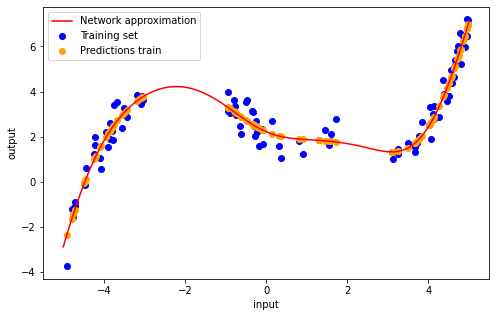

###############################################################################



In [ ]:
torch.manual_seed(1)
np.random.seed(0)

# K-FOLDS CROSS-VALIDATION
kf = KFold(n_splits=10, shuffle=True, random_state=0)

num_epochs = 500
patience = 500

# Network parameters
Ni = 1
No = 1

# GRID-SEARCH
HL_vector = [2, 3]
Nh_vector = [16, 32, 64]
activation_vector = [nn.Tanh(), nn.LeakyReLU(), nn.Softplus()]
# # GELU: smooth ReLU
lr_vector = [0.01, 0.001]

# Nh_vector = [16]
# activation_vector = [nn.Sigmoid()]
# lr_vector = [0.01]

results = []

for (HL, Nh, act, lr) in tq.tqdm(list(itertools.product(HL_vector, 
                                                        Nh_vector, 
                                                        activation_vector,
                                                        lr_vector)),
                                 desc = 'GRID SEARCH PROGRESS'):
  
    print(f'\nTraining the Network with {HL} hidden layers of {Nh} neurons, act = {act} and lr = {lr}')

    train_loss_vec = []
    val_loss_vec = []
    

    for fold, (train_index, test_index) in enumerate(tq.tqdm(kf.split(train_df), 
                                                             desc = f'CV',
                                                             total = 10)):

        # DATASET AND DATALOADER
        train_dataloader, val_dataloader = MyDataLoader(train_df, train_index, test_index, train_batch_size = 18)

        # NETWORK INITIALIZATION
        torch.manual_seed(0)
        net = Net5(Ni, Nh, No, HL, act, reg=False)
        net.to(device)

        # Define the loss function
        loss_function = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        # TRAINING LOOP
        train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                    train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
        train_loss_vec.append(train_loss), val_loss_vec.append(val_loss)

        # if fold == 0:
        #     # Plot losses
        #     plot_losses(train_loss_log, val_loss_log)

        #     printModel(net)

            # print('------------------------------------------------------------------------------')   

    #     printModel(net)

    mean_train_loss = np.mean(train_loss_vec)
    mean_val_loss = np.mean(val_loss_vec)

    k = f'{HL} hidden layers, {Nh} neurons, act = {act} and lr = {lr}'
    results.append((k, mean_val_loss))

    print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 


    # --- Full training ---

    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                          fold, patience = 1000)
    
    # Print model
    printFinalModel(net)

    # print(f'Average validation loss: {np.mean(val_loss_vec):.5f}') 
    print('###############################################################################')

In [ ]:
results_sorted = sorted(results, key=lambda tup: tup[1])
results_sorted

[('3 hidden layers, 64 neurons, act = Tanh() and lr = 0.001', 0.2838148),
 ('3 hidden layers, 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.001',
  0.28497112),
 ('3 hidden layers, 32 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01',
  0.28663513),
 ('2 hidden layers, 32 neurons, act = Tanh() and lr = 0.01', 0.2897666),
 ('3 hidden layers, 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01',
  0.29081258),
 ('3 hidden layers, 32 neurons, act = LeakyReLU(negative_slope=0.01) and lr = 0.001',
  0.29110044),
 ('2 hidden layers, 64 neurons, act = Tanh() and lr = 0.001', 0.2928724),
 ('2 hidden layers, 64 neurons, act = Tanh() and lr = 0.01', 0.2946505),
 ('3 hidden layers, 64 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01',
  0.29483443),
 ('3 hidden layers, 32 neurons, act = Tanh() and lr = 0.001', 0.29495612),
 ('2 hidden layers, 16 neurons, act = Softplus(beta=1, threshold=20) and lr = 0.01',
  0.30007428),
 ('2 hidden layers, 64 neuron

### Changing the number of epochs

#### ELU


Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 100 epochs



Avg train loss: 0.33979, Avg val loss: 0.36028


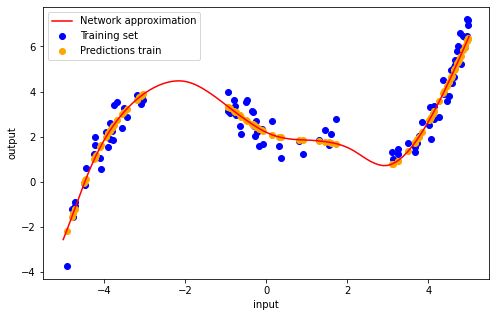

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 250 epochs



Avg train loss: 0.22774, Avg val loss: 0.26555


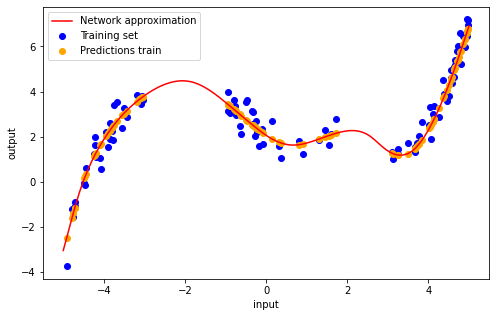

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 500 epochs



Avg train loss: 0.21909, Avg val loss: 0.26482


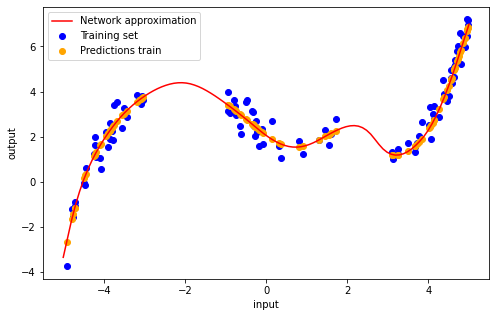

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 1000 epochs



Avg train loss: 0.20976, Avg val loss: 0.28220


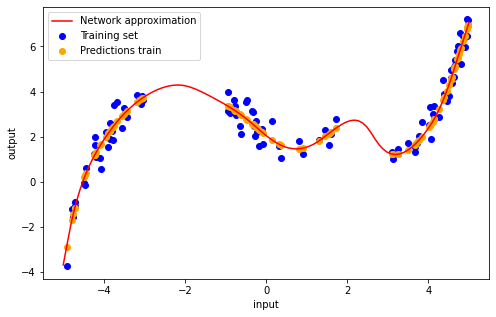

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 2000 epochs



Avg train loss: 0.19914, Avg val loss: 0.28705


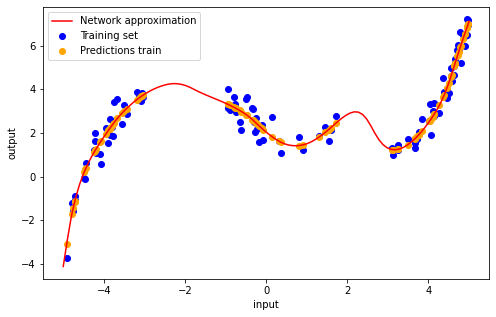

###############################################################################

Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 5000 epochs



Avg train loss: 0.17547, Avg val loss: 0.30546


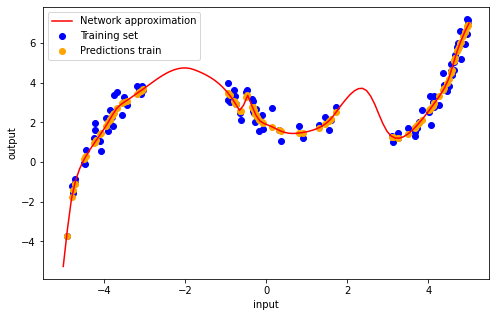

###############################################################################



In [ ]:
# hidden neurons 16, 32, 64
# Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.001

torch.manual_seed(1)
np.random.seed(0)

# K-FOLDS CROSS-VALIDATION
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# num_epochs = 500
patience = 5000

# Network parameters
Ni = 1
No = 1

# GRID-SEARCH
HL_vector = [3]
Nh_vector = [64]
activation_vector = [nn.ELU()]
lr_vector = [0.001]
num_epoch_vector = [100, 250, 500, 1000, 2000, 5000]

results = []

for (HL, Nh, act, lr, num_epochs) in tq.tqdm(list(itertools.product(HL_vector, 
                                                        Nh_vector, 
                                                        activation_vector,
                                                        lr_vector,
                                                        num_epoch_vector)),
                                 desc = 'GRID SEARCH PROGRESS'):
  
    print(f'\nTraining the Network with {HL} hidden layers of {Nh} neurons, act = {act}, lr = {lr} and {num_epochs} epochs')

    train_loss_vec = []
    val_loss_vec = []
    

    for fold, (train_index, test_index) in enumerate(tq.tqdm(kf.split(train_df), 
                                                             desc = f'CV',
                                                             total = 10)):

        # DATASET AND DATALOADER
        train_dataloader, val_dataloader = MyDataLoader(train_df, train_index, test_index, train_batch_size = 18)

        # NETWORK INITIALIZATION
        torch.manual_seed(0)
        net = Net5(Ni, Nh, No, HL, act, reg=False)
        net.to(device)

        # Define the loss function
        loss_function = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        # TRAINING LOOP
        train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                    train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
        train_loss_vec.append(train_loss), val_loss_vec.append(val_loss)

        # if fold == 0:
        #     # Plot losses
        #     plot_losses(train_loss_log, val_loss_log)

        #     printModel(net)

            # print('------------------------------------------------------------------------------')   

    #     printModel(net)

    mean_train_loss = np.mean(train_loss_vec)
    mean_val_loss = np.mean(val_loss_vec)

    k = f'{HL} hidden layers, {Nh} neurons, act = {act}, lr = {lr} and {num_epochs} epochs'
    results.append((k, mean_val_loss))

    print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 


    # --- Full training ---

    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                          fold, patience = 1000)
    
    # Print model
    printFinalModel(net)

    # print(f'Average validation loss: {np.mean(val_loss_vec):.5f}') 
    print('###############################################################################')

In [ ]:
results_sorted = sorted(results, key=lambda tup: tup[1])
results_sorted

[('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 500 epochs',
  0.26481745),
 ('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 250 epochs',
  0.265548),
 ('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 1000 epochs',
  0.2821957),
 ('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 2000 epochs',
  0.28704822),
 ('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 5000 epochs',
  0.30545992),
 ('3 hidden layers, 64 neurons, act = ELU(alpha=1.0), lr = 0.001 and 100 epochs',
  0.3602803)]

#### GELU


Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 100 epochs



Avg train loss: 0.59344, Avg val loss: 0.67539


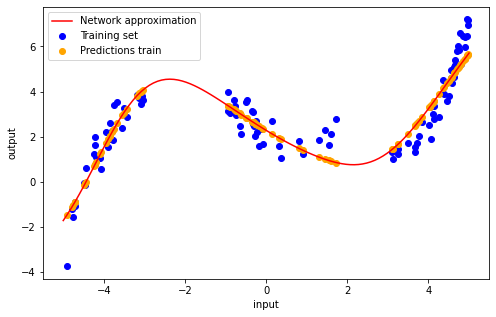

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 250 epochs



Avg train loss: 0.23871, Avg val loss: 0.29278


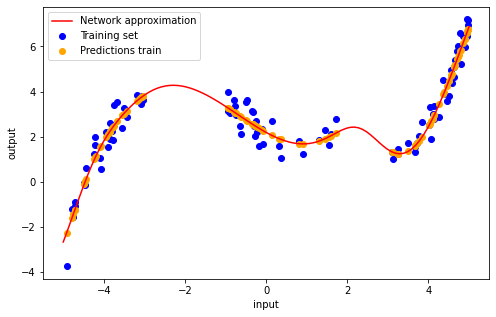

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 500 epochs



Avg train loss: 0.21313, Avg val loss: 0.27287


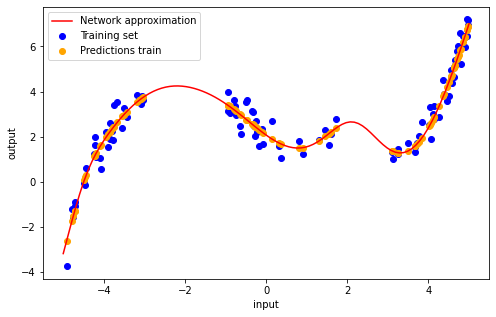

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 1000 epochs



Avg train loss: 0.20245, Avg val loss: 0.27070


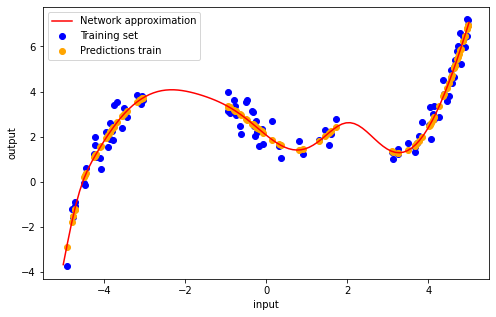

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 2000 epochs



Avg train loss: 0.19326, Avg val loss: 0.27723


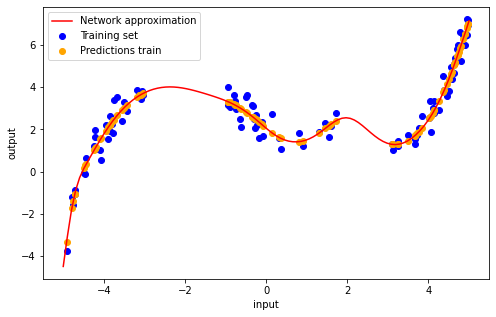

###############################################################################

Training the Network with 3 hidden layers of 32 neurons, act = GELU(), lr = 0.001 and 5000 epochs



Avg train loss: 0.17517, Avg val loss: 0.30078


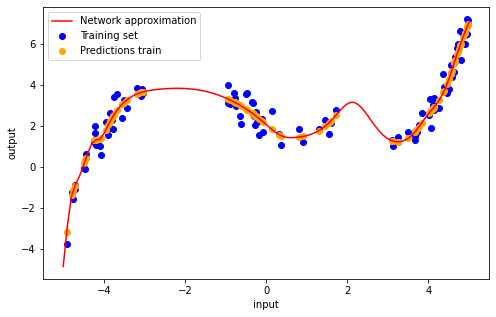

###############################################################################



In [ ]:
# hidden neurons 16, 32, 64
# Training the Network with 3 hidden layers of 32 neurons, act = GELU() and lr = 0.001

torch.manual_seed(1)
np.random.seed(0)

# K-FOLDS CROSS-VALIDATION
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# num_epochs = 500
patience = 5000

# Network parameters
Ni = 1
No = 1

# GRID-SEARCH
HL_vector = [3]
Nh_vector = [32]
activation_vector = [nn.GELU()]
lr_vector = [0.001]
num_epoch_vector = [100, 250, 500, 1000, 2000, 5000]

results = []

for (HL, Nh, act, lr, num_epochs) in tq.tqdm(list(itertools.product(HL_vector, 
                                                        Nh_vector, 
                                                        activation_vector,
                                                        lr_vector,
                                                        num_epoch_vector)),
                                 desc = 'GRID SEARCH PROGRESS'):
  
    print(f'\nTraining the Network with {HL} hidden layers of {Nh} neurons, act = {act}, lr = {lr} and {num_epochs} epochs')

    train_loss_vec = []
    val_loss_vec = []
    

    for fold, (train_index, test_index) in enumerate(tq.tqdm(kf.split(train_df), 
                                                             desc = f'CV',
                                                             total = 10)):

        # DATASET AND DATALOADER
        train_dataloader, val_dataloader = MyDataLoader(train_df, train_index, test_index, train_batch_size = 18)

        # NETWORK INITIALIZATION
        torch.manual_seed(0)
        net = Net5(Ni, Nh, No, HL, act, reg=False)
        net.to(device)

        # Define the loss function
        loss_function = nn.MSELoss()

        # Define the optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr)

        # TRAINING LOOP
        train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                    train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
        train_loss_vec.append(train_loss), val_loss_vec.append(val_loss)

        # if fold == 0:
        #     # Plot losses
        #     plot_losses(train_loss_log, val_loss_log)

        #     printModel(net)

            # print('------------------------------------------------------------------------------')   

    #     printModel(net)

    mean_train_loss = np.mean(train_loss_vec)
    mean_val_loss = np.mean(val_loss_vec)

    k = f'{HL} hidden layers, {Nh} neurons, act = {act}, lr = {lr} and {num_epochs} epochs'
    results.append((k, mean_val_loss))

    print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 


    # --- Full training ---

    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                          fold, patience = 1000)
    
    # Print model
    printFinalModel(net)

    # print(f'Average validation loss: {np.mean(val_loss_vec):.5f}') 
    print('###############################################################################')

In [ ]:
results_sorted = sorted(results, key=lambda tup: tup[1])
results_sorted

[('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 1000 epochs',
  0.27069858),
 ('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 500 epochs',
  0.2728706),
 ('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 2000 epochs',
  0.27723217),
 ('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 250 epochs',
  0.29278117),
 ('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 5000 epochs',
  0.30078417),
 ('3 hidden layers, 32 neurons, act = GELU(), lr = 0.001 and 100 epochs',
  0.67539036)]

# Final model evaluation

### ELU

FINAL TRAINING LOSS: 0.21838624775409698


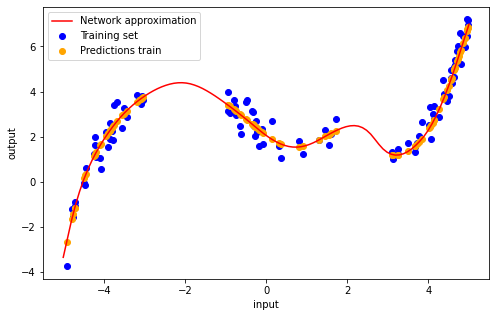

In [ ]:
# Best model
# Training the Network with 3 hidden layers of 64 neurons, act = ELU(alpha=1.0) and lr = 0.001

torch.manual_seed(1)
np.random.seed(0)

num_epochs = 500
patience = 5000

# NETWORK INITIALIZATION
torch.manual_seed(0)
net = Net5(Ni=1, Nh=64, No=1, HL=3, activation=nn.ELU(), reg=False)
net.to(device)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Full training
train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                        fold, patience = 1000)

print(f'FINAL TRAINING LOSS: {train_loss}')

# Print model
printFinalModel(net)

In [ ]:
# Test set evaluation
all_outputs_v, all_labels_v = [], []

net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
with torch.no_grad(): # Disable gradient tracking during validation
    for sample_batched in test_dataloader: #only 1 batch of 100 samples!
        
        # Move data to device
        x_test = sample_batched[0].to(device)
        label_test = sample_batched[1].to(device)

        # Forward pass
        out = net(x_test)

        # Compute loss
        loss = loss_function(out, label_test)

        # Save test loss and the output for this batch
        loss = loss.detach().cpu().numpy()
        print(f'FINAL TEST LOSS: {loss}')

FINAL TEST LOSS: 0.04957130178809166


In [ ]:
# Network output
x_vec = torch.linspace(-5,5,100)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)

net.eval()
with torch.no_grad():
    y_vec = net(x_vec)

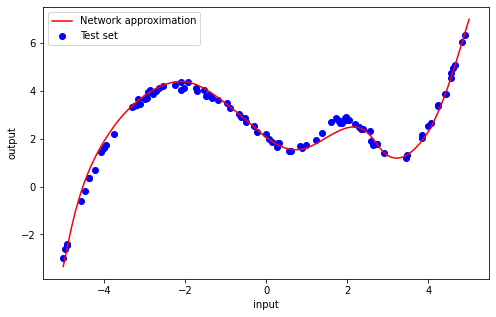

In [ ]:
# Plot output
plt.figure(figsize=(8,5))
plt.plot(x_vec.cpu(), y_vec.cpu(), label='Network approximation', color = 'red')
plt.scatter(x_test.cpu(), label_test.cpu(), label='Test set', color = 'blue')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.show()

### GELU

FINAL TRAINING LOSS: 0.20351667702198029


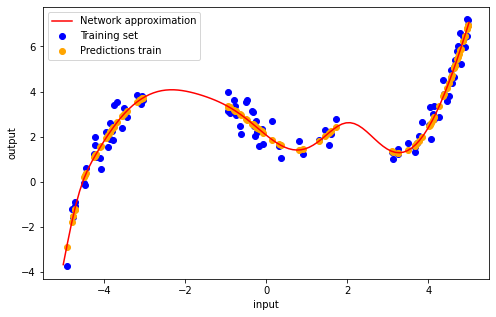

In [ ]:
# Best model
# Training the Network with 3 hidden layers of 32 neurons, act = GELU() and lr = 0.001

torch.manual_seed(1)
np.random.seed(0)

num_epochs = 1000
patience = 5000

# NETWORK INITIALIZATION
torch.manual_seed(0)
net = Net5(Ni=1, Nh=32, No=1, HL=3, activation=nn.GELU(), reg=False)
net.to(device)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Full training
train_loss_log, train_loss, net = training_loop_final(net, train_dataloader_original, loss_function, optimizer, num_epochs, 
                                                        fold, patience = 1000)

print(f'FINAL TRAINING LOSS: {train_loss}')

# Print model
printFinalModel(net)

In [ ]:
# Test set evaluation
all_outputs_v, all_labels_v = [], []

net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
with torch.no_grad(): # Disable gradient tracking during validation
    for sample_batched in test_dataloader: #only 1 batch of 100 samples!
        
        # Move data to device
        x_test = sample_batched[0].to(device)
        label_test = sample_batched[1].to(device)

        # Forward pass
        out = net(x_test)

        # Compute loss
        loss = loss_function(out, label_test)

        # Save test loss and the output for this batch
        loss = loss.detach().cpu().numpy()
        print(f'FINAL TEST LOSS: {loss}')

FINAL TEST LOSS: 0.045196037739515305


In [ ]:
# Network output
x_vec = torch.linspace(-5,5,100)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)

net.eval()
with torch.no_grad():
    y_vec = net(x_vec)

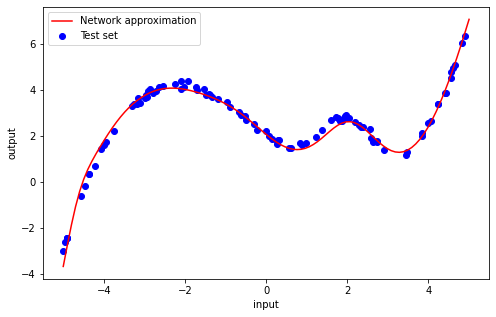

In [ ]:
# Plot output
plt.figure(figsize=(8,5))
plt.plot(x_vec.cpu(), y_vec.cpu(), label='Network approximation', color = 'red')
plt.scatter(x_test.cpu(), label_test.cpu(), label='Test set', color = 'blue')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.show()

# Nested cross-validation

In this additional section, I show a possible way to implement a nested cross-validation. First of all, I merge the training and test sets.

### Merge training and test set

In [36]:
traintest = [train_df, test_df]
dataset = pd.concat(traintest)
dataset

input     label
26 -3.946958  2.201153
86  4.960311  6.460902
2  -3.855373  2.621375
55  0.811964  1.834054
75  4.972470  7.152546
..       ...       ...
95 -2.029013  4.130353
96  0.313855  1.835889
97 -3.108990  3.434612
98 -0.213557  2.281842
99  3.842187  2.013707

[200 rows x 2 columns]

### Nested cross-validation loop

The outer CV considered has 4 folds, meaning that I perform 4 iterations and in each of them 75% of the dataset will form the training/validation set and the remaining 25% the test set. Since I will obtain 4 different test evaluation, I will report the average value of the loss function along with its standard deviation.

Inside each iteration of the outer loop, the following happens.
The training/validation set is object of another CV, this time of 5 folds. The purpose of this part is to optimize the hyper-parameters. In this simple example, I considered just the number of hidden layers with possible values 2 and 3. After having found the configuration offering the best average validation loss, we exit the inner loop, retrain the model in the full training/validation set and evaluate it the the test set.

In [47]:
torch.manual_seed(1)
np.random.seed(0)

# Initializzation
num_epochs = 100
patience = 100
# Network parameters
Ni = 1
No = 1


######## 4-FOLDS CROSS-VALIDATION: outer loop
kf_out = KFold(n_splits=4, shuffle=True, random_state=0)
trainval_loss_vec = [] # Here I will store 4 values
test_loss_vec = [] # Here I will store 4 values

for fold_out, (train_index_out, test_index) in enumerate(tq.tqdm(kf_out.split(dataset), 
                                                            desc = f'INNER CV',
                                                            total = 4)):
    
    print(f'\n------------------------------- OUTER FOLD {fold_out +1}/4 -------------------------------')

    # Create the trainval and test dataloader for the outer loop
    test = dataset.iloc[test_index]
    test_dataset = PandasDataset(test, transform=composed_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)

    train_val_df = dataset.iloc[train_index_out]
    
    train_val_df_copy = train_val_df.copy()
    train_dataset_original = PandasDataset(train_val_df_copy, transform=composed_transform)
    train_dataloader_original = DataLoader(train_dataset_original, batch_size=30, shuffle=False, num_workers=0)


    ####### 5-FOLDS CROSS-VALIDATION: inner loop
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    # GRID-SEARCH
    HL_vector = [2, 3]
    Nh_vector = [16]
    activation_vector = [nn.ELU()]
    lr_vector = [0.01]

    results = []

    for (HL, Nh, act, lr) in tq.tqdm(list(itertools.product(HL_vector, 
                                                            Nh_vector, 
                                                            activation_vector,
                                                            lr_vector)),
                                    desc = 'GRID SEARCH PROGRESS'):
    
        print(f'\nTraining the Network with {HL} hidden layers')

        train_loss_vec = []
        val_loss_vec = []
        
        print('---------------- STARTING INNER LOOP ----------------')
        for fold, (train_index, val_index) in enumerate(tq.tqdm(kf.split(train_val_df), 
                                                                desc = f'OUTER CV',
                                                                total = 5)):
            
            print(f'Inner fold {fold+1}/5')

            # DATASET AND DATALOADER
            train_dataloader, val_dataloader = MyDataLoader(train_val_df, train_index, val_index, 
                                                            train_batch_size = 30, val_batch_size=30)

            # NETWORK INITIALIZATION
            torch.manual_seed(0)
            net = Net5(Ni, Nh, No, HL, act, reg=False)
            net.to(device)

            # Define the loss function
            loss_function = nn.MSELoss()

            # Define the optimizer
            optimizer = optim.Adam(net.parameters(), lr=lr)

            # TRAINING LOOP
            train_loss_log, val_loss_log, train_loss, val_loss, net = training_loop(net, 
                                                        train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, fold, patience)
            train_loss_vec.append(train_loss); val_loss_vec.append(val_loss)

        mean_train_loss = np.mean(train_loss_vec)
        mean_val_loss = np.mean(val_loss_vec)

        # k = f'{HL} hidden layers, {Nh} neurons, act = {act} and lr = {lr}'
        results.append((HL, mean_val_loss))

        print(f'Avg train loss: {mean_train_loss:.5f}, Avg val loss: {mean_val_loss:.5f}') 

        print('---------------- INNER LOOP ENDED ----------------')    
    # --- Full training ---

    # Select the best hyper-parameters according to the inner loop
    results_sorted = sorted(results, key=lambda tup: tup[1])
    best_HL = results_sorted[0][0]
    print(f'\nThe best value for HL is {best_HL}')

    print('\nTraining in the merged training + validation set')
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    net = Net5(Ni, Nh, No, best_HL, act, reg=False)
    net.to(device)

    # Define the loss function
    loss_function = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Training loop on the full training-validation set
    trainval_loss_log, test_loss_log, trainval_loss, test_loss, net = training_loop(net, 
                                                        train_dataloader_original, test_dataloader, loss_function, 
                                                        optimizer, num_epochs, fold, patience)
    trainval_loss_vec.append(trainval_loss); test_loss_vec.append(test_loss)

    print(f'Trainval loss: {trainval_loss:.5f}, Test loss: {test_loss:.5f}') 


mean_trainval_loss = np.mean(train_loss_vec)
sd_train_loss = np.std(train_loss_vec)
mean_test_loss = np.mean(test_loss_vec)
sd_test_loss = np.std(test_loss_vec)

print(f'Average train-val loss: {mean_trainval_loss}, with a standard deviation of {sd_train_loss}')
print(f'Average test loss: {mean_test_loss}, with a standard deviation of {sd_test_loss}')



------------------------------- OUTER FOLD 1/4 -------------------------------



Training the Network with 2 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.43628, Avg val loss: 0.45398
---------------- INNER LOOP ENDED ----------------

Training the Network with 3 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.42885, Avg val loss: 0.34030
---------------- INNER LOOP ENDED ----------------


The best value for HL is 3

Training in the merged training + validation set
Trainval loss: 0.30903, Test loss: 0.23996

------------------------------- OUTER FOLD 2/4 -------------------------------



Training the Network with 2 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.53073, Avg val loss: 0.63058
---------------- INNER LOOP ENDED ----------------

Training the Network with 3 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.39093, Avg val loss: 0.42878
---------------- INNER LOOP ENDED ----------------


The best value for HL is 3

Training in the merged training + validation set
Trainval loss: 0.42320, Test loss: 0.33878

------------------------------- OUTER FOLD 3/4 -------------------------------



Training the Network with 2 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.53218, Avg val loss: 0.56218
---------------- INNER LOOP ENDED ----------------

Training the Network with 3 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.29542, Avg val loss: 0.31715
---------------- INNER LOOP ENDED ----------------


The best value for HL is 3

Training in the merged training + validation set
Trainval loss: 0.30353, Test loss: 0.20487

------------------------------- OUTER FOLD 4/4 -------------------------------



Training the Network with 2 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.54245, Avg val loss: 0.64462
---------------- INNER LOOP ENDED ----------------

Training the Network with 3 hidden layers
---------------- STARTING INNER LOOP ----------------


Inner fold 1/5
Inner fold 2/5
Inner fold 3/5
Inner fold 4/5
Inner fold 5/5

Avg train loss: 0.34199, Avg val loss: 0.34948
---------------- INNER LOOP ENDED ----------------


The best value for HL is 3

Training in the merged training + validation set
Trainval loss: 0.23038, Test loss: 0.25836

Average train-val loss: 0.34199458360671997, with a standard deviation of 0.07373839616775513
Average test loss: 0.26049214601516724, with a standard deviation of 0.04911179468035698
